In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Model imports
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.neural_network import MLPRegressor

# Custom module imports
import feature_engineering
import helper_functions
import problem

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
np.random.seed(42)

In [4]:
iteration_number = datetime.datetime.now().strftime("%Y%m%d%H%M")

In [5]:
# Define the path and filename for saving tuning results
results_path = f"./model_iterations/iteration_{iteration_number}"

# Ensure the results_path exists
if not os.path.exists(results_path):
    os.makedirs(results_path)

# Load Data

In [6]:
X_train, y_train = problem.get_train_data("..", basic=False)
X_test, y_test = problem.get_test_data("..")

In [7]:
# Path to results 
path_tuning = "tuning_results"

# Initalizing the Pipe

In [8]:
def init_pipe(cyclic=True):
    """
    Initialize the preprocessing pipeline.
    
    Args:
        cyclic (bool): If True, use cyclic features. Otherwise, use one-hot encoding.
        
    Returns:
        A tuple of (feature_transformer, data_preprocessor).
    """
    # Feature categories
    if cyclic == True:
        date_features = ["hour_cos", "hour_sin", "month_cos", "month_sin", "weekday_cos", "weekday_sin", "day_cos", "day_sin",
                         "week_cos", "week_sin"]
        cyclic_condition = ("date_passthrough", "passthrough", date_features)
    else:
        date_features = ["hour", "month"]
        cyclic_condition = ("date_onehot", OneHotEncoder(handle_unknown="ignore"), date_features)
        # Removed: "day", "week", "weekday", 

    numeric_features = ['temp', 'precip', 'cloudcover', 'windspeed', 'humidity', 'velib_min', 'latitude', 'longitude']
    # Removed: 'velib_mean', 'velib_std', 'velib_25%', 

    categorical_features = ["counter_name", "site_name", "year"]

    binary_features = ["precipprob", "is_Bank_Holiday", "if_School_Holiday", "is_workday", "in_Lockdown", "is_Rush_Hour"]
    # Removed:

    # Function to transform and add additional features
    feature_transformer = FunctionTransformer(feature_engineering._additional_features)

    # Preprocessing pipeline
    data_preprocessor = ColumnTransformer([
        ("numeric_scaler", StandardScaler(), numeric_features),
        ("categorical_onehot", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("binary_passthrough", "passthrough", binary_features),
        cyclic_condition
    ])
    
    return feature_transformer, data_preprocessor


# Model Evaluation

## LightGBM

In [9]:
light_gbm_params = pd.read_csv(os.path.join(path_tuning, 'tuning_LightGBM/202311291749_results.csv'))

In [10]:
light_gbm_max_params = light_gbm_params.loc[light_gbm_params['mean_test_score'] == light_gbm_params['mean_test_score'].max()]


In [11]:
best_params = ast.literal_eval(light_gbm_max_params.params.values[0])
params_new = {key.split('__')[1]: value for key, value in best_params.items()}

In [12]:
params_new

{'colsample_bytree': 0.6312688677841224,
 'learning_rate': 0.1,
 'min_child_samples': 11,
 'n_estimators': 93,
 'num_leaves': 46,
 'reg_alpha': 0.6715218672675088,
 'reg_lambda': 0.3595973728296669,
 'subsample': 0.39036704409810985,
 'subsample_freq': 5}

In [13]:
print(f"Mean Train set, RMSE = {light_gbm_max_params['mean_train_score'].values[0]:.2f}")
print(f"Mean Test  set, RMSE = {light_gbm_max_params['mean_test_score'].values[0]:.2f}")

Mean Train set, RMSE = -0.48
Mean Test  set, RMSE = -0.70


In [14]:
# Define hyperparameters for tuning
model = LGBMRegressor(**params_new)

In [15]:
feature_transformer, data_preprocessor = init_pipe(False)
lgbm_reg_pipe = make_pipeline(feature_transformer, data_preprocessor, model)
lgbm_reg_pipe.fit(X_train, y_train)

y_train_prediction = lgbm_reg_pipe.predict(X_train)
y_test_prediction = lgbm_reg_pipe.predict(X_test)

In [16]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, y_train_prediction, squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, y_test_prediction, squared=False):.2f}"
)

Train set, RMSE=0.53
Test set, RMSE=0.47


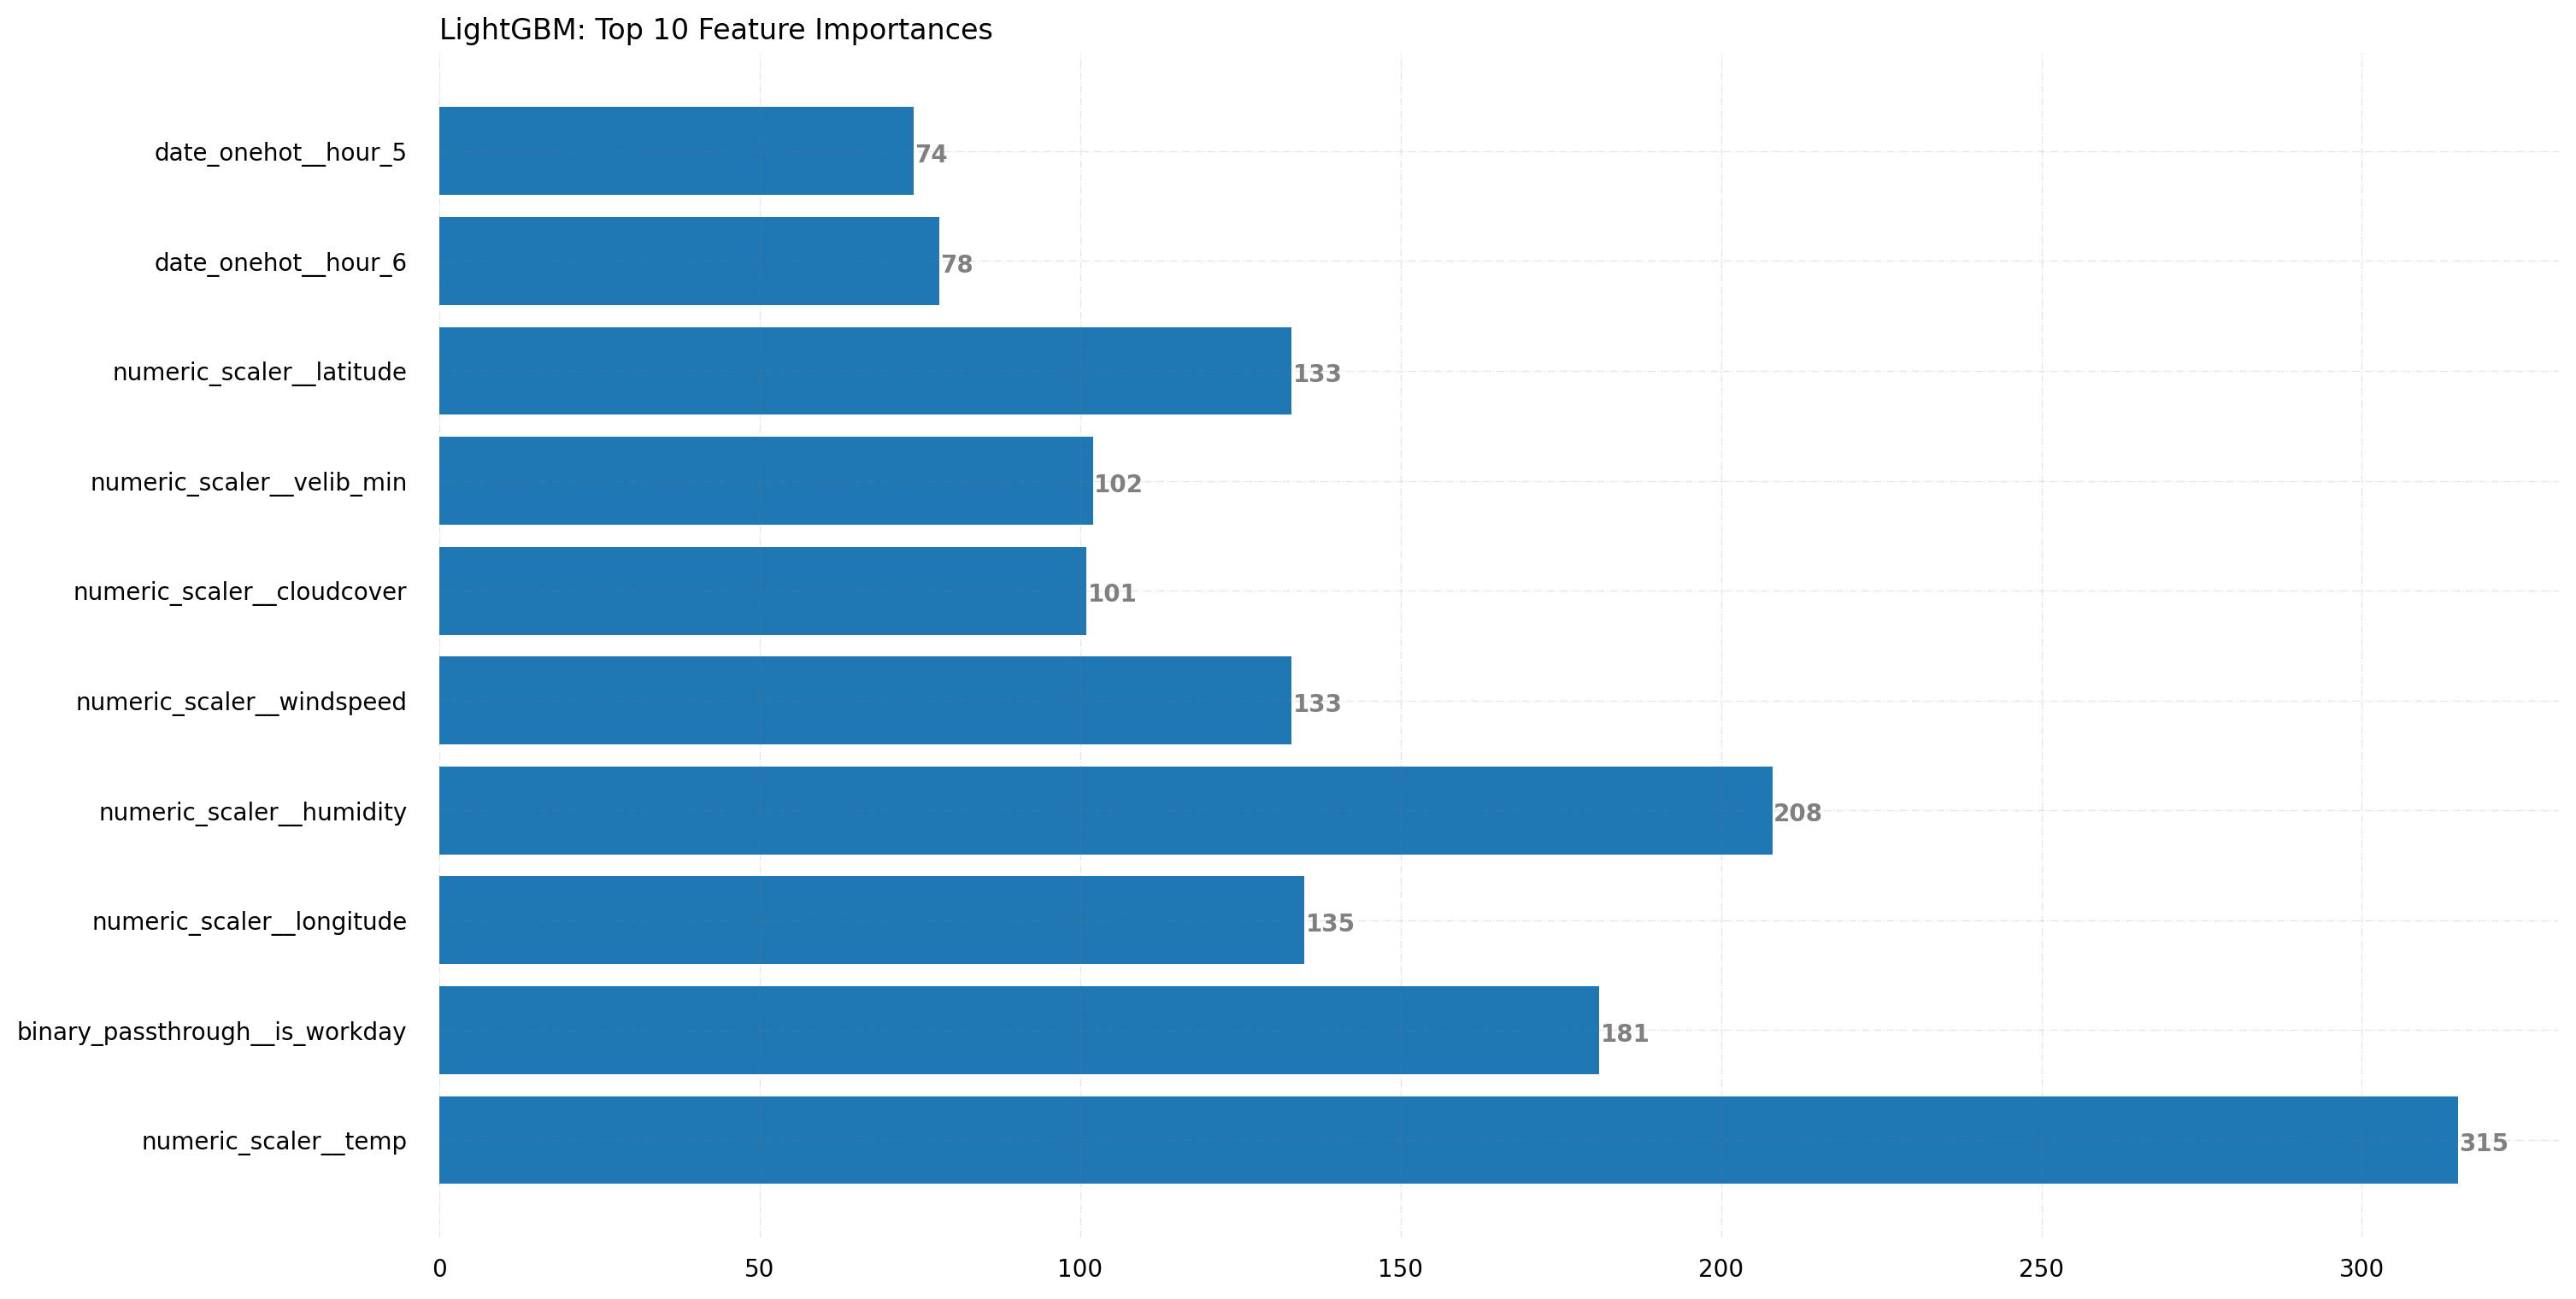

In [17]:
ind = np.argpartition(model.feature_importances_, -10)[-10:]

features = data_preprocessor.get_feature_names_out()[ind]
importance = model.feature_importances_[ind]

helper_functions.feature_importance(features, importance, 'LightGBM', results_path)

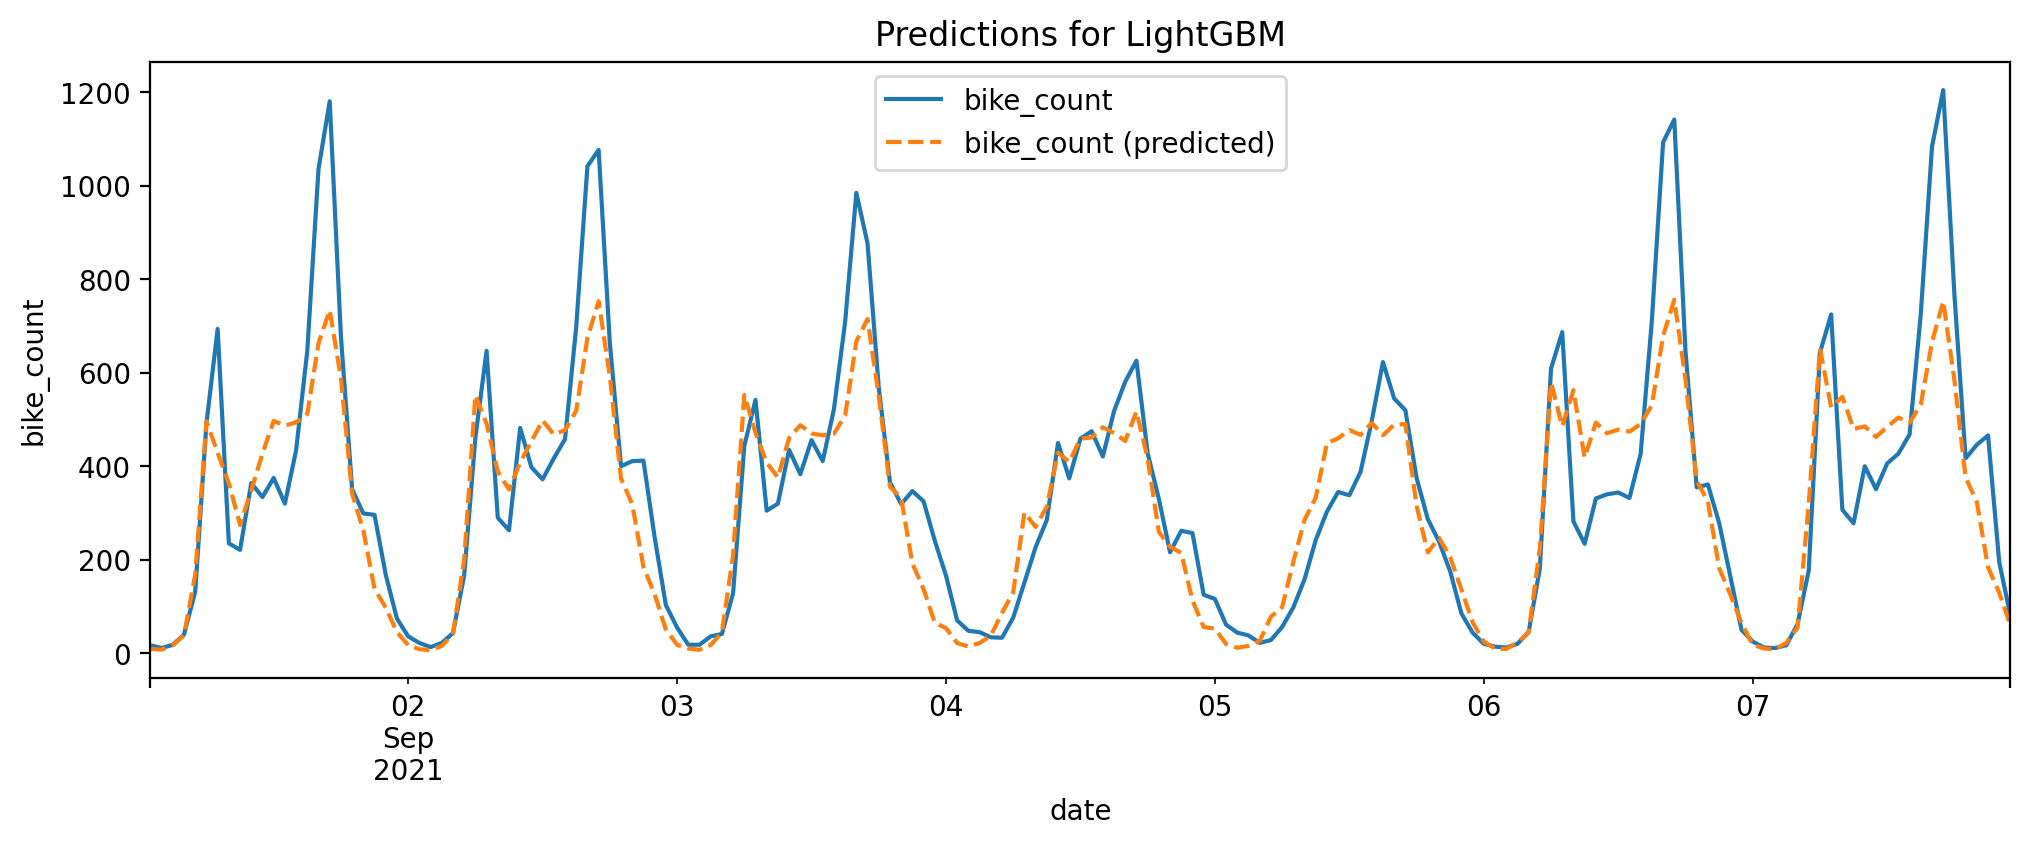

In [18]:
helper_functions.sample_week_plot(X_test, y_test_prediction, y_test, 'LightGBM', results_path)

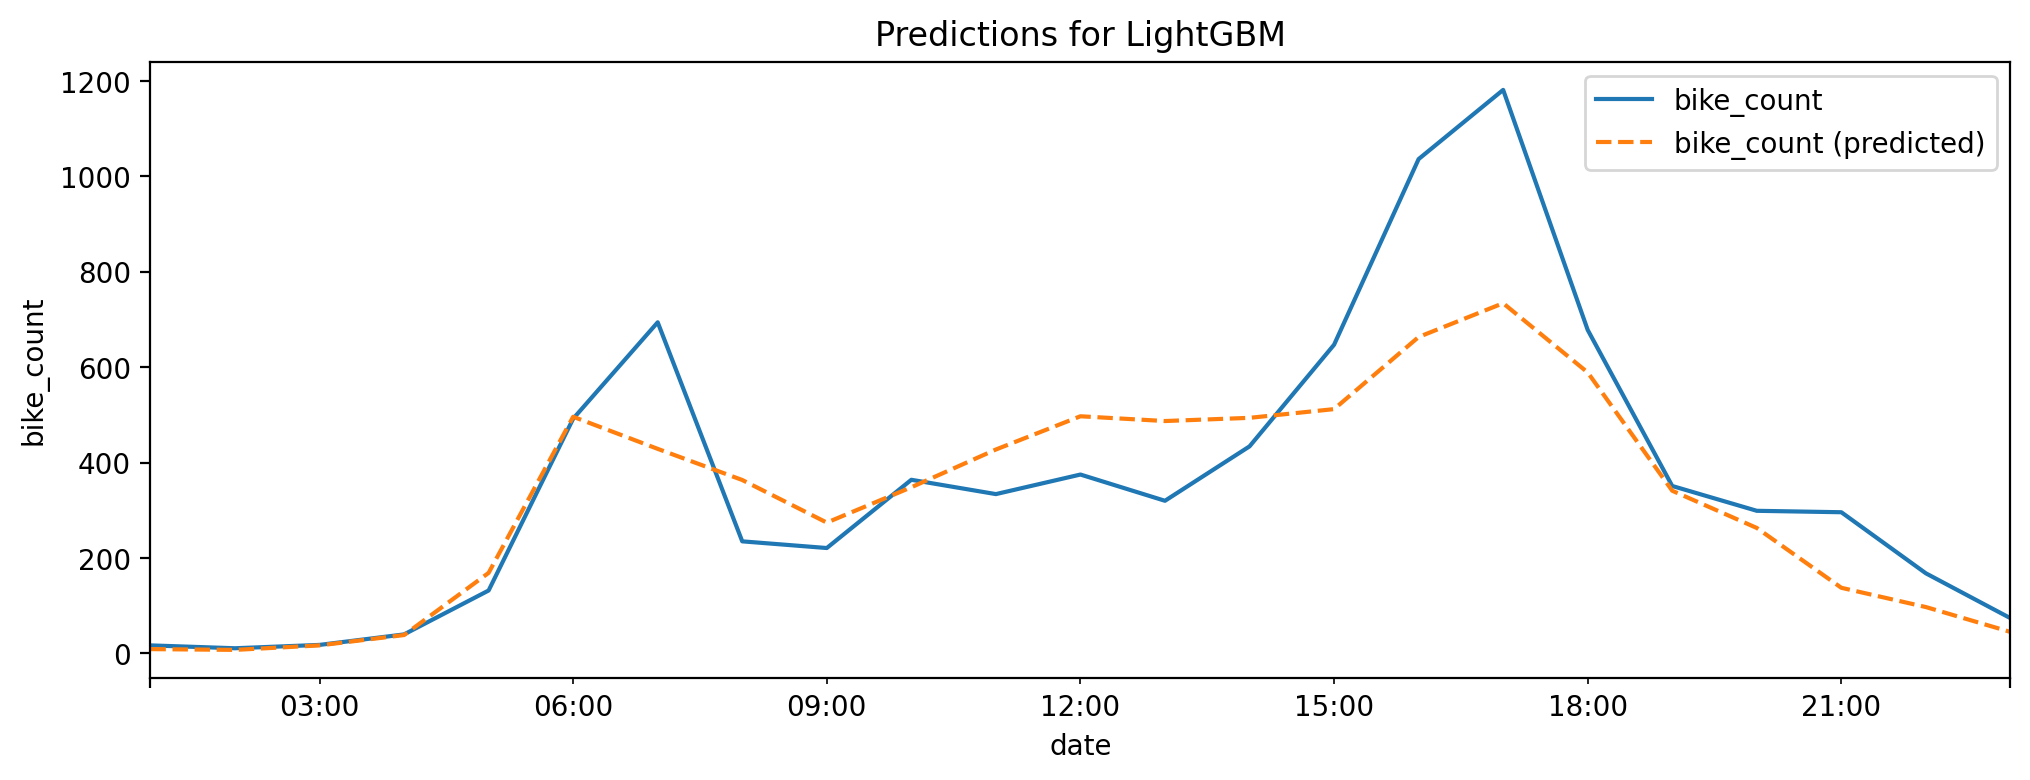

In [19]:
helper_functions.sample_day_plot(X_test, y_test_prediction, y_test, 'LightGBM', results_path)

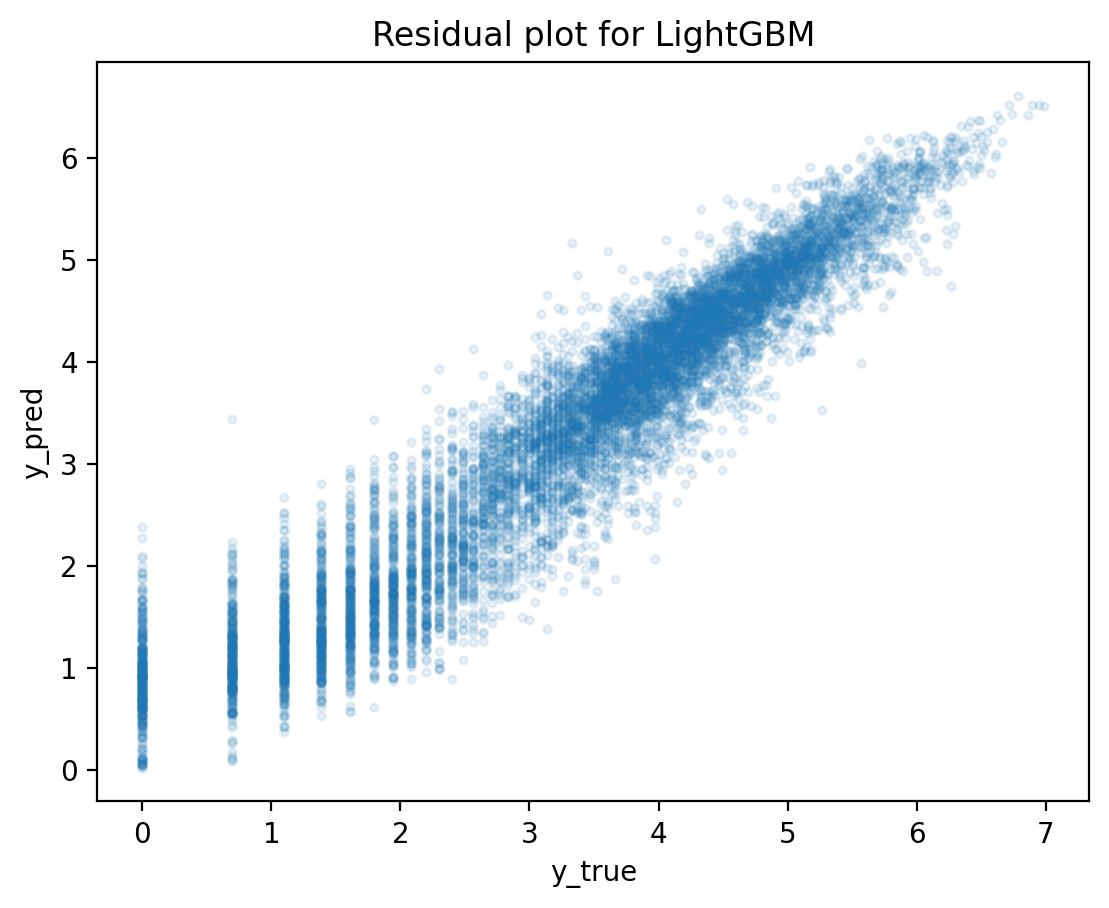

In [20]:
helper_functions.residual_plot(y_test_prediction, y_test, 'LightGBM', results_path)

# XGBoost

In [85]:
xgb_params = pd.read_csv(os.path.join(path_tuning, 'tuning_XGB/best_202312061125_results.csv'))

In [86]:
xgb_max_params = xgb_params.loc[xgb_params['mean_test_score'] == xgb_params['mean_test_score'].max()]

In [87]:
best_params = ast.literal_eval(xgb_max_params.params.values[0])
params_new = {key.split('__')[1]: value for key, value in best_params.items()}

In [88]:
params_new

{'colsample_bylevel': 0.581656400761972,
 'colsample_bynode': 0.8200386107664507,
 'colsample_bytree': 0.9615880546827551,
 'gamma': 3.2214343252131696,
 'learning_rate': 0.06492828175147727,
 'max_depth': 22,
 'n_estimators': 162,
 'reg_alpha': 1.1067526143124211,
 'reg_lambda': 1.2581608887925084,
 'subsample': 0.7684439793860398}

In [91]:
print(f"Mean Train set, RMSE = {xgb_max_params['mean_train_score'].values[0]:.2f}")
print(f"Mean Test  set, RMSE = {xgb_max_params['mean_test_score'].values[0]:.2f}")

Mean Train set, RMSE = -0.34
Mean Test  set, RMSE = -0.64


In [92]:
# Define hyperparameters for tuning
model = XGBRegressor(**params_new)

In [93]:

feature_transformer, data_preprocessor = init_pipe(True)
xgb_reg_pipe = make_pipeline(feature_transformer, data_preprocessor, model)
xgb_reg_pipe.fit(X_train, y_train)

y_train_prediction = xgb_reg_pipe.predict(X_train)
y_test_prediction = xgb_reg_pipe.predict(X_test)

In [94]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, y_train_prediction, squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, y_test_prediction, squared=False):.2f}"
)

Train set, RMSE=0.32
Test set, RMSE=0.30


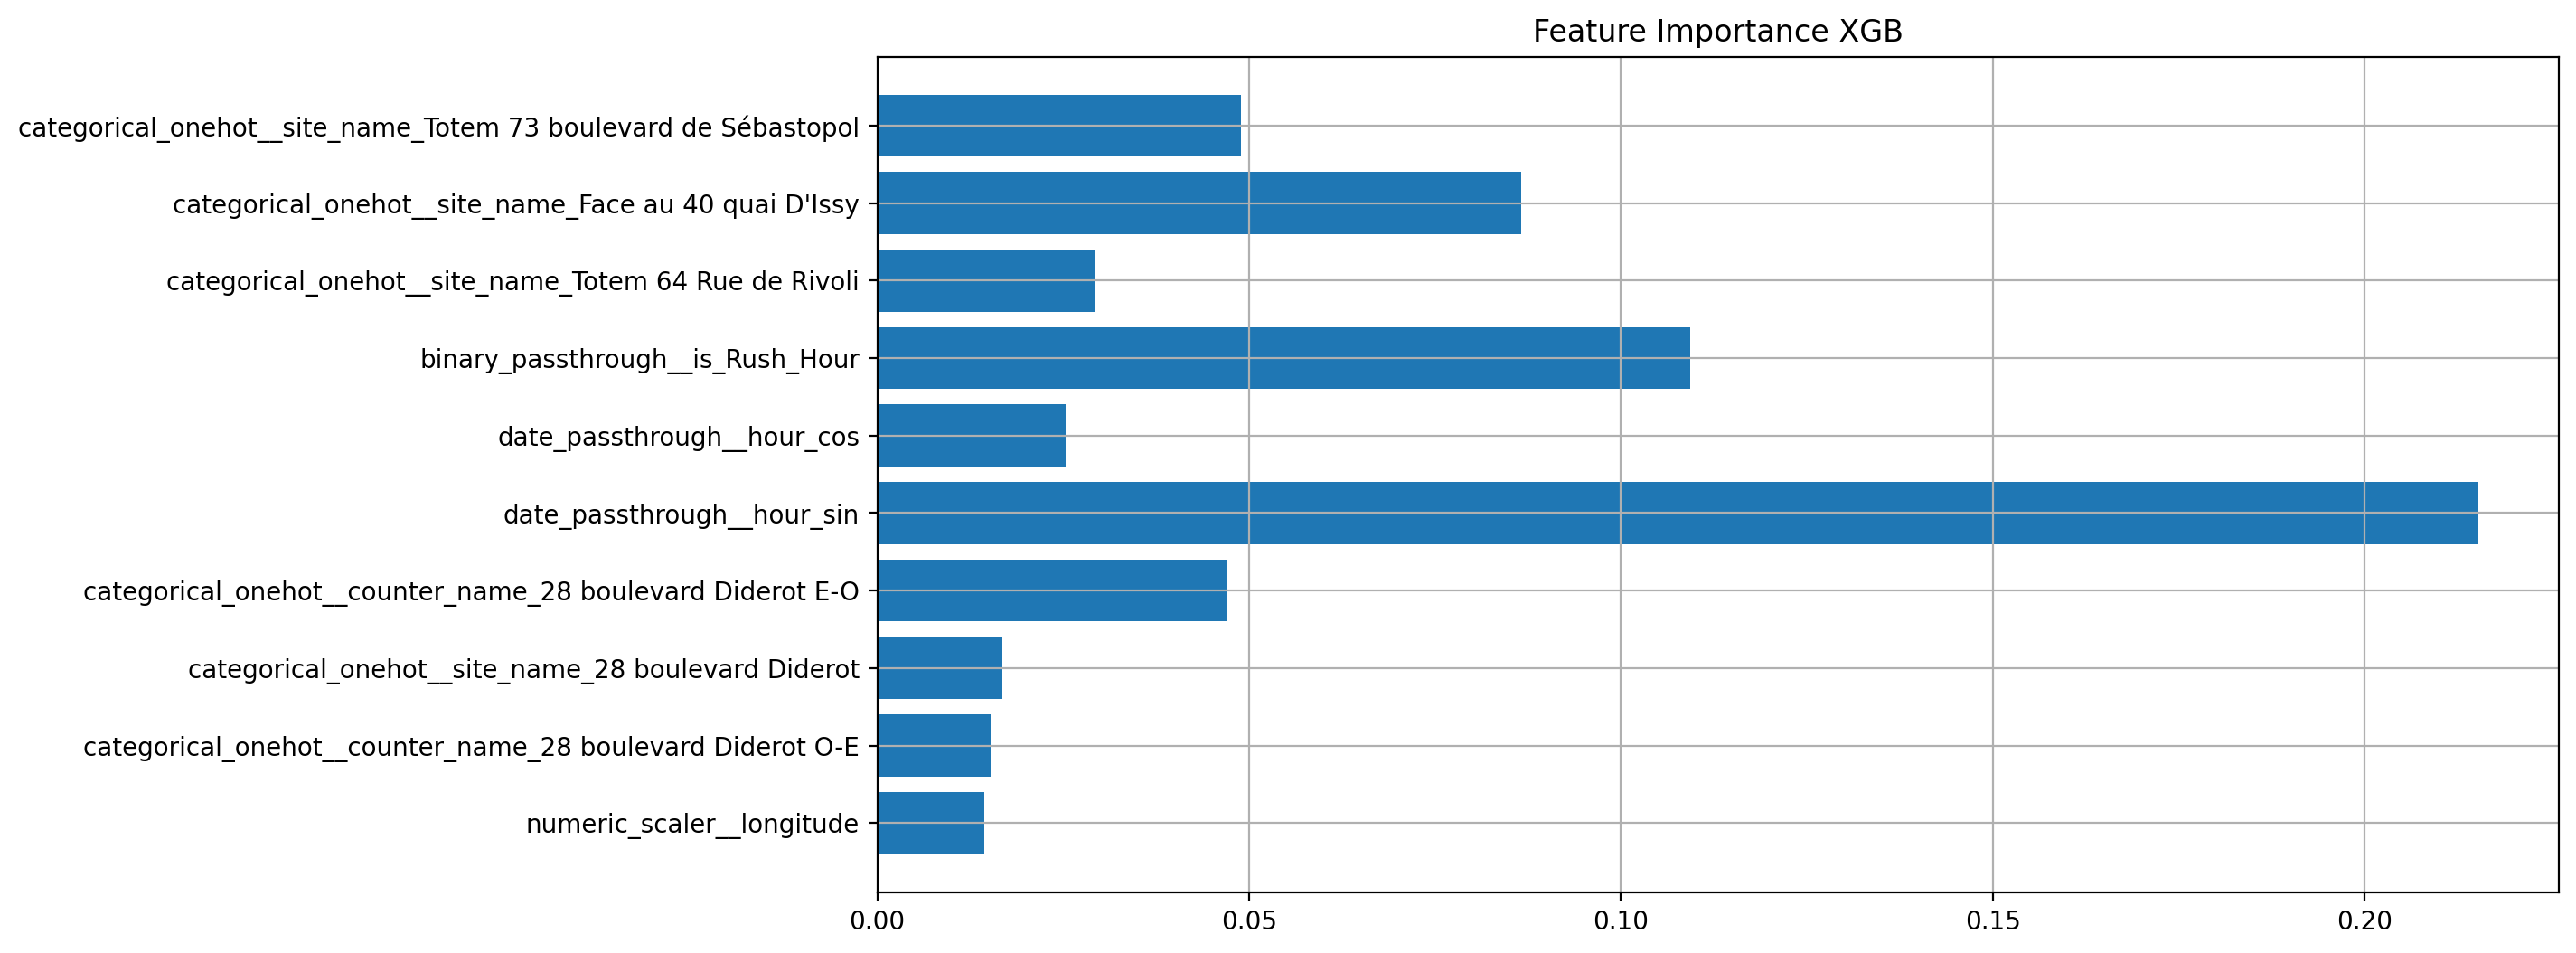

In [96]:
ind = np.argpartition(model.feature_importances_, -10)[-10:]

features = data_preprocessor.get_feature_names_out()[ind]
importance = model.feature_importances_[ind]

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(ind)), importance, align='center')
plt.yticks(range(len(ind)), features)
plt.title('Feature Importance XGB')
plt.grid()
plt.savefig(f'{results_path}/feature_importance_XGB.png')

plt.show()

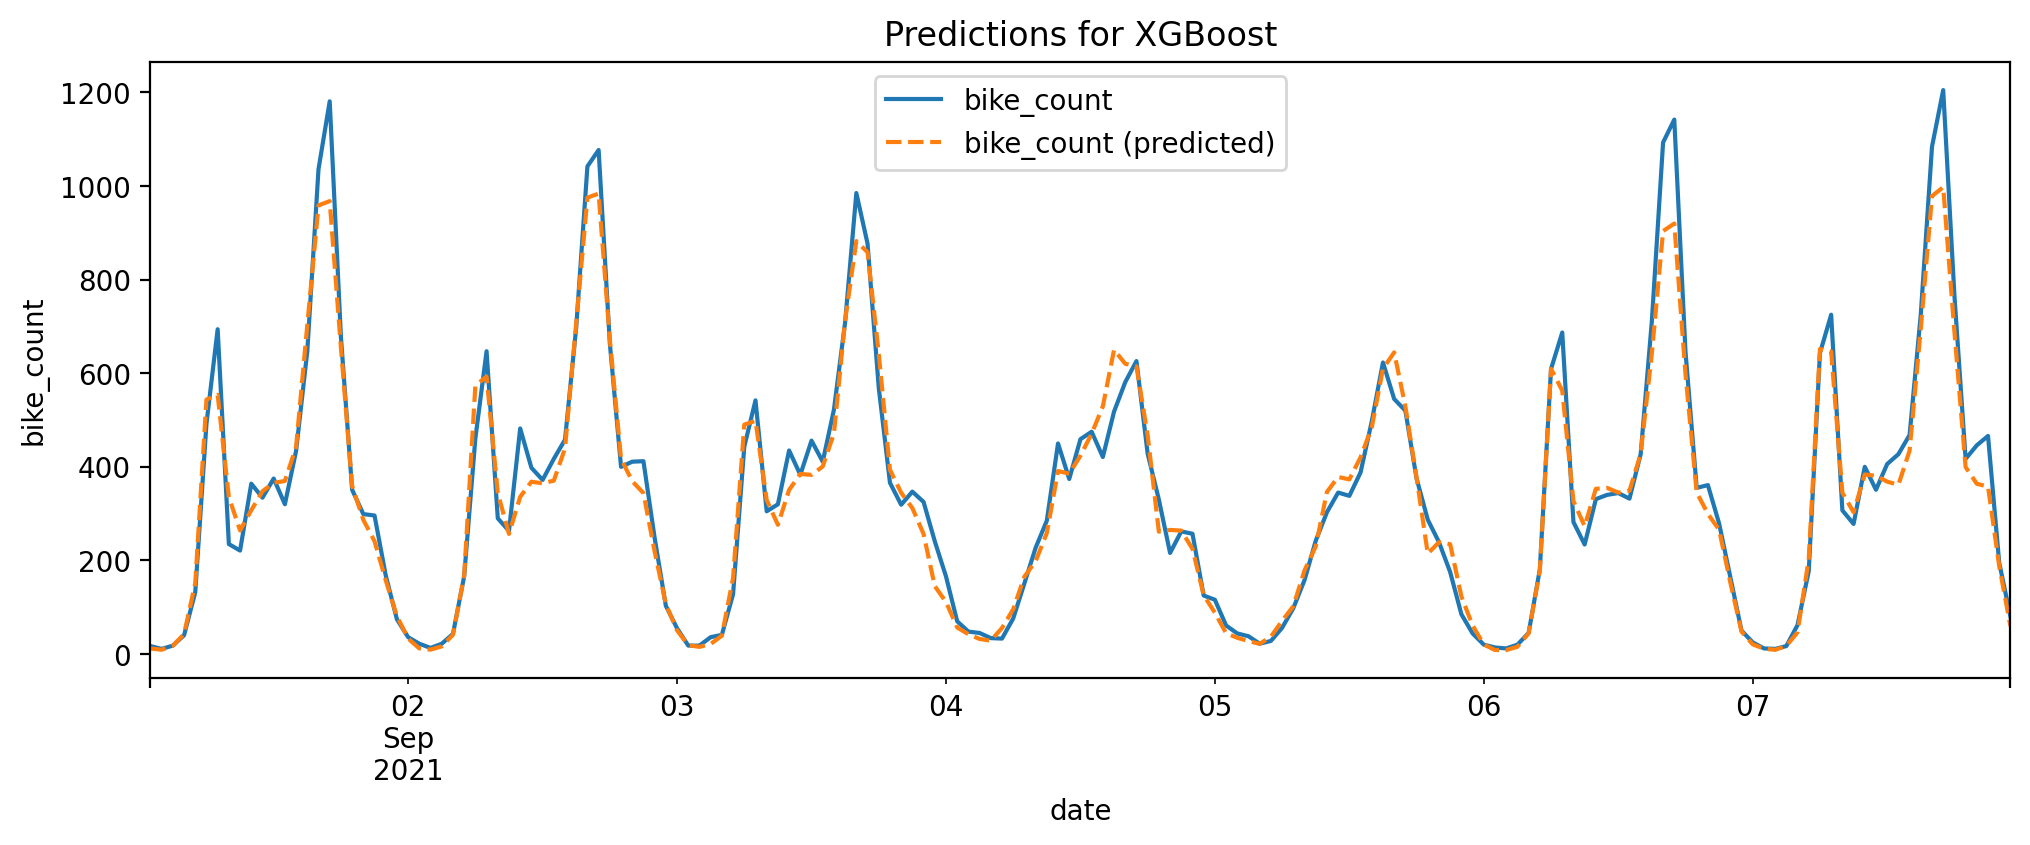

In [30]:
helper_functions.sample_week_plot(X_test, y_test_prediction, y_test, 'XGBoost', results_path)


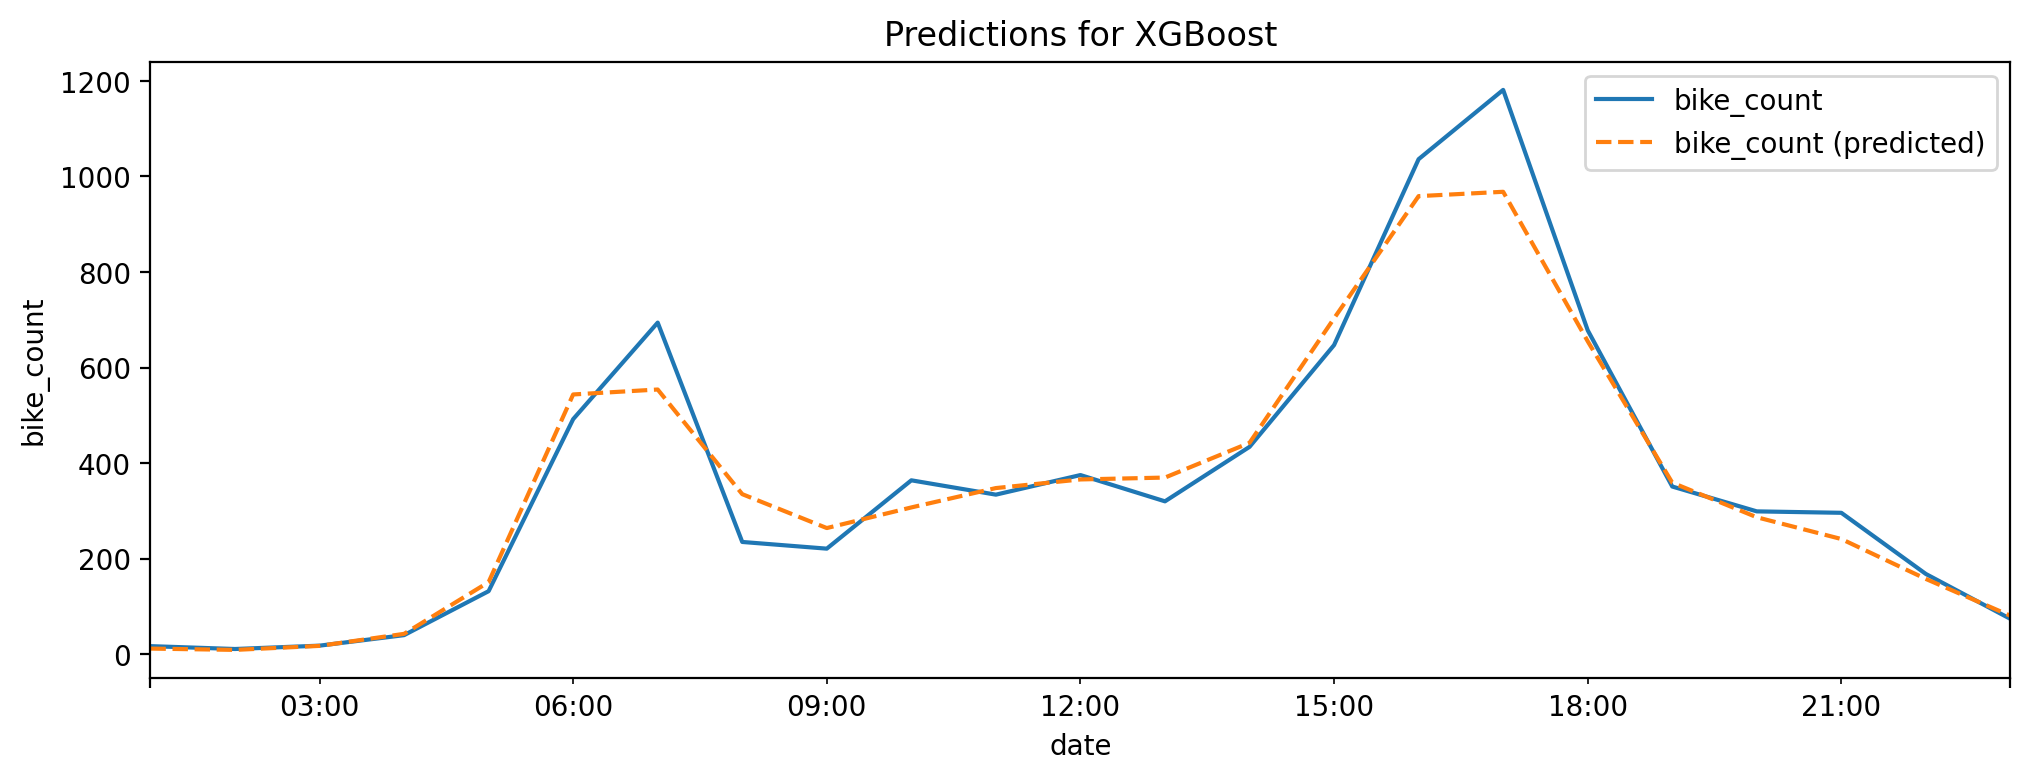

In [31]:
helper_functions.sample_day_plot(X_test, y_test_prediction, y_test, 'XGBoost', results_path)


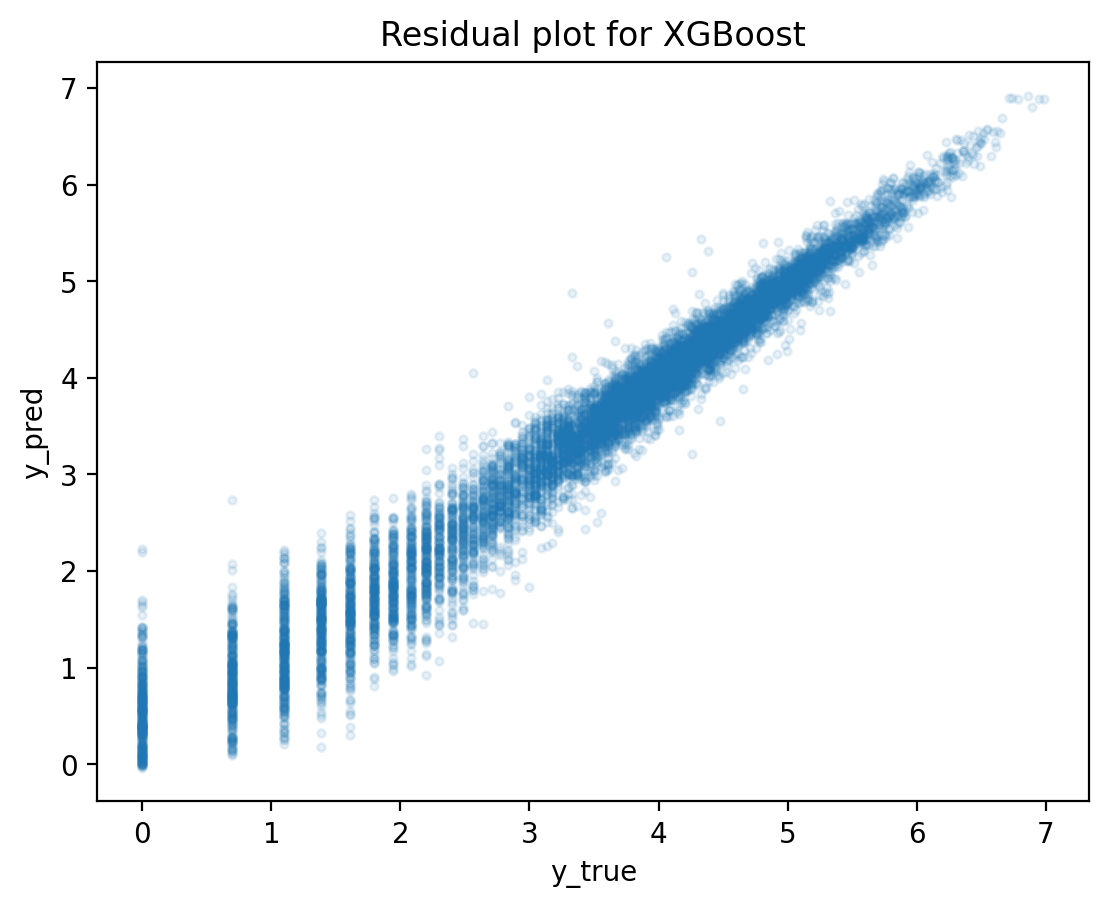

In [32]:
helper_functions.residual_plot(y_test_prediction, y_test, 'XGBoost', results_path)


## MLP Network

In [33]:
mlp_params = pd.read_csv(os.path.join(path_tuning, 'tuning_mlp/202311291529_results.csv'))

In [34]:
mlp_max_params = mlp_params.loc[mlp_params['mean_test_score'] == mlp_params['mean_test_score'].max()]

In [35]:
best_params = ast.literal_eval(mlp_max_params.params.values[0])
params_new = {key.split('__')[1]: value for key, value in best_params.items()}

In [36]:
params_new

{'activation': 'relu',
 'alpha': 0.24346326796176587,
 'hidden_layer_sizes': (5, 5),
 'learning_rate': 'constant',
 'learning_rate_init': 0.006618138134673482,
 'max_iter': 372,
 'solver': 'adam'}

In [37]:
print(f"Mean Train set, RMSE = {mlp_max_params['mean_train_score'].values[0]:.2f}")
print(f"Mean Test  set, RMSE = {mlp_max_params['mean_test_score'].values[0]:.2f}")

Mean Train set, RMSE = -0.55
Mean Test  set, RMSE = -0.69


In [38]:
# Define hyperparameters for tuning
model = MLPRegressor(**params_new)

In [39]:
feature_transformer, data_preprocessor = init_pipe()
mlp_reg_pipe = make_pipeline(feature_transformer, data_preprocessor, model)
mlp_reg_pipe.fit(X_train, y_train)

y_train_prediction = mlp_reg_pipe.predict(X_train)
y_test_prediction = mlp_reg_pipe.predict(X_test)

In [40]:
#helper_functions.predict_final_test(mlp_reg_pipe)

In [41]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, y_train_prediction, squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, y_test_prediction, squared=False):.2f}"
)

Train set, RMSE=0.57
Test set, RMSE=0.50


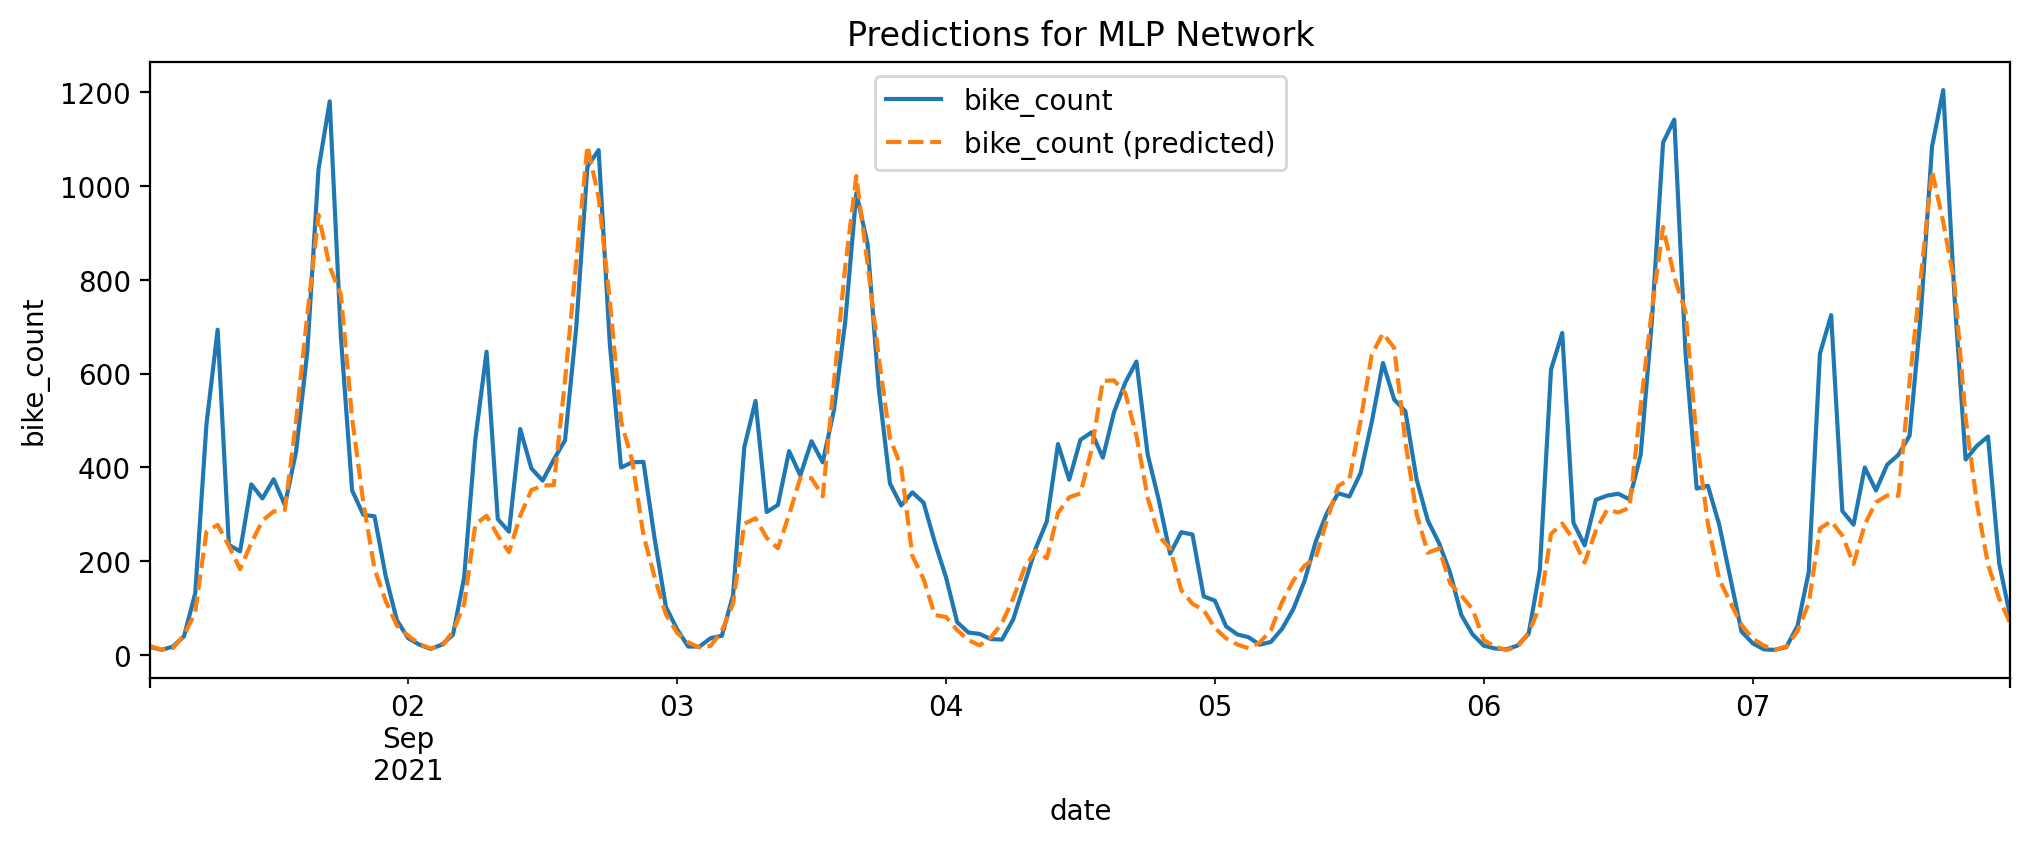

In [42]:
helper_functions.sample_week_plot(X_test, y_test_prediction, y_test, 'MLP Network', results_path)

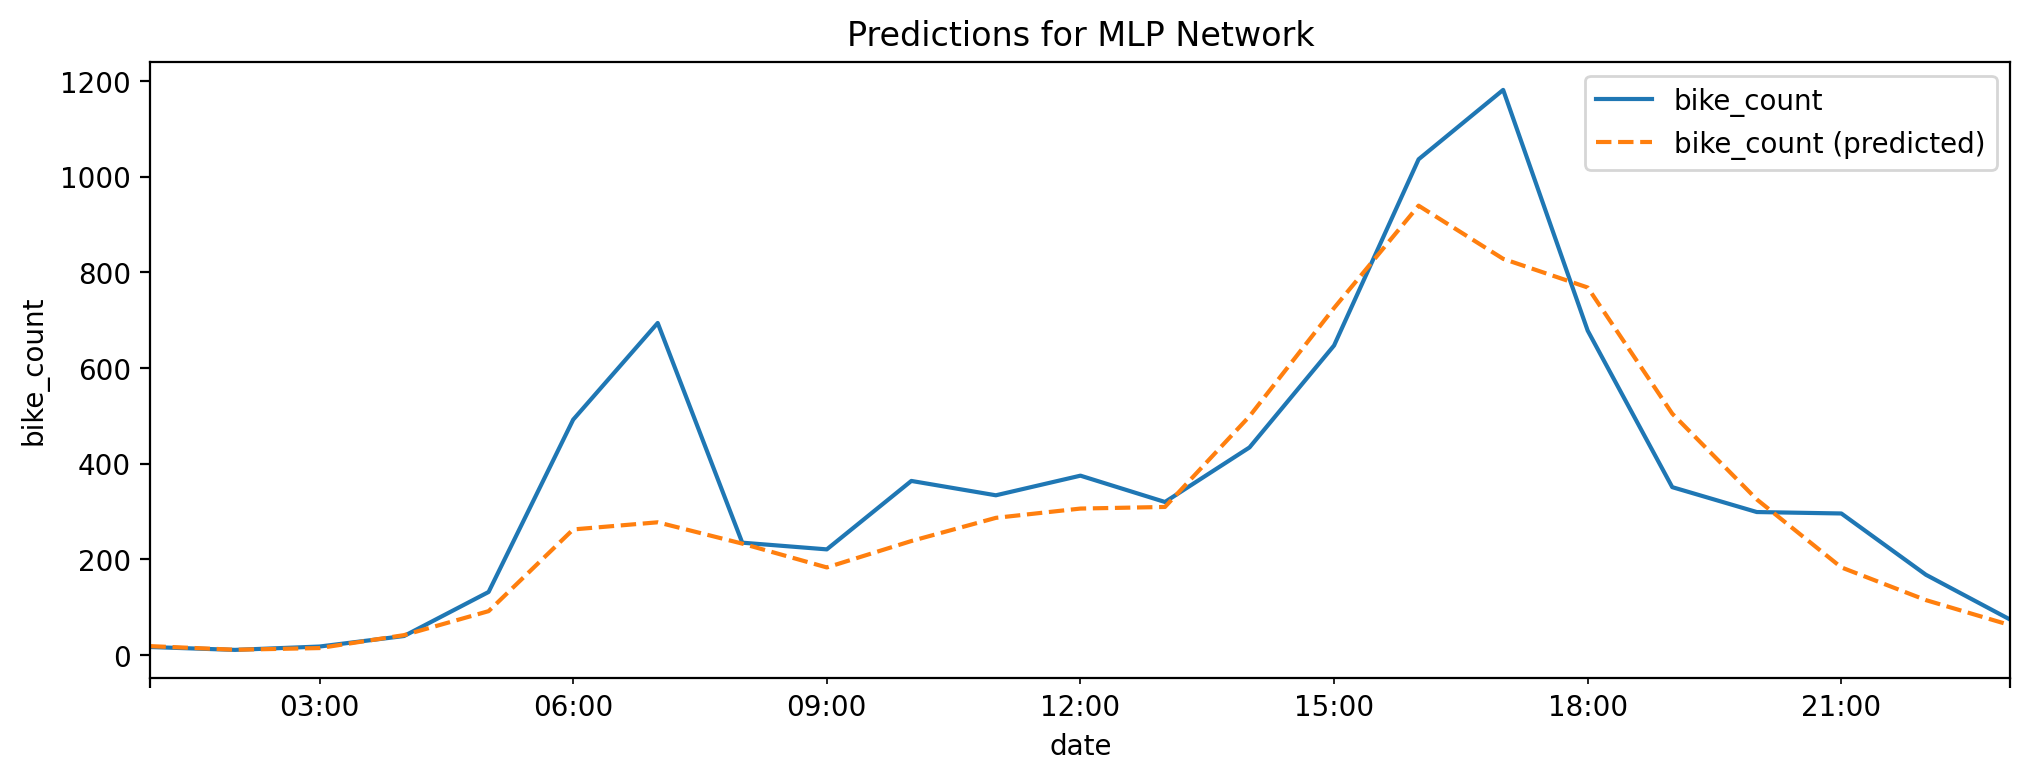

In [43]:
helper_functions.sample_day_plot(X_test, y_test_prediction, y_test, 'MLP Network', results_path)

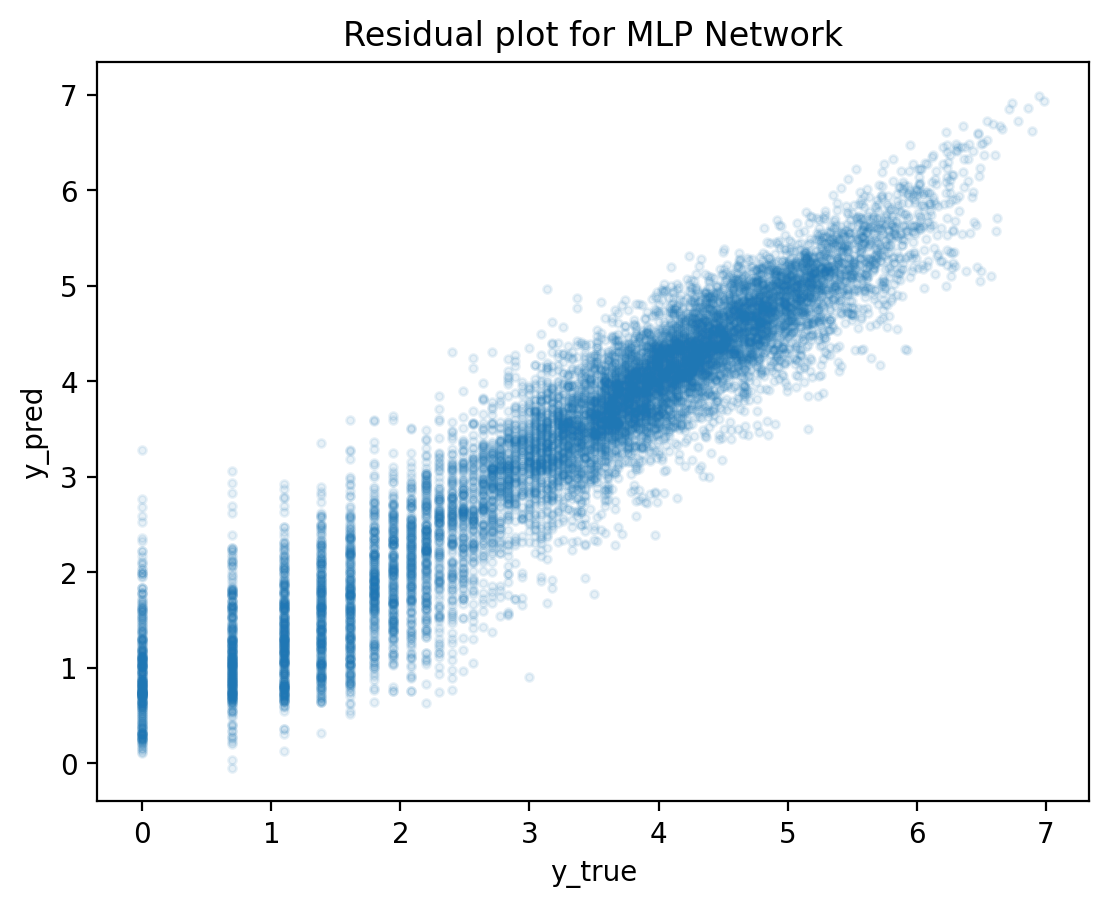

In [44]:
helper_functions.residual_plot(y_test_prediction, y_test, 'MLP Network', results_path)

## ElasticNet

In [45]:
elasticnet_params = pd.read_csv(os.path.join(path_tuning, 'tuning_ElasticNet/202311271926_results.csv'))

In [46]:
elasticnet_max_params = elasticnet_params.loc[elasticnet_params['mean_test_score'] == elasticnet_params['mean_test_score'].max()]

In [51]:
best_params = ast.literal_eval(elasticnet_max_params.params.values[0])
params_new = {key.split('__')[1]: value for key, value in best_params.items()}

In [52]:
params_new

{'alpha': 0.014260501289848038, 'l1_ratio': 0.2405733384927975}

In [53]:
print(f"Mean Train set, RMSE = {elasticnet_params['mean_train_score'].values[0]:.2f}")
print(f"Mean Test  set, RMSE = {elasticnet_params['mean_test_score'].values[0]:.2f}")

Mean Train set, RMSE = -1.07
Mean Test  set, RMSE = -1.11


In [54]:
# Define hyperparameters for tuning
model = ElasticNet(**params_new)

In [55]:
feature_transformer, data_preprocessor = init_pipe(False)
elastic_reg_pipe = make_pipeline(feature_transformer, data_preprocessor, model)
elastic_reg_pipe.fit(X_train, y_train)

y_train_prediction = elastic_reg_pipe.predict(X_train)
y_test_prediction = elastic_reg_pipe.predict(X_test)

In [56]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, y_train_prediction, squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, y_test_prediction, squared=False):.2f}"
)

Train set, RMSE=0.81
Test set, RMSE=0.69


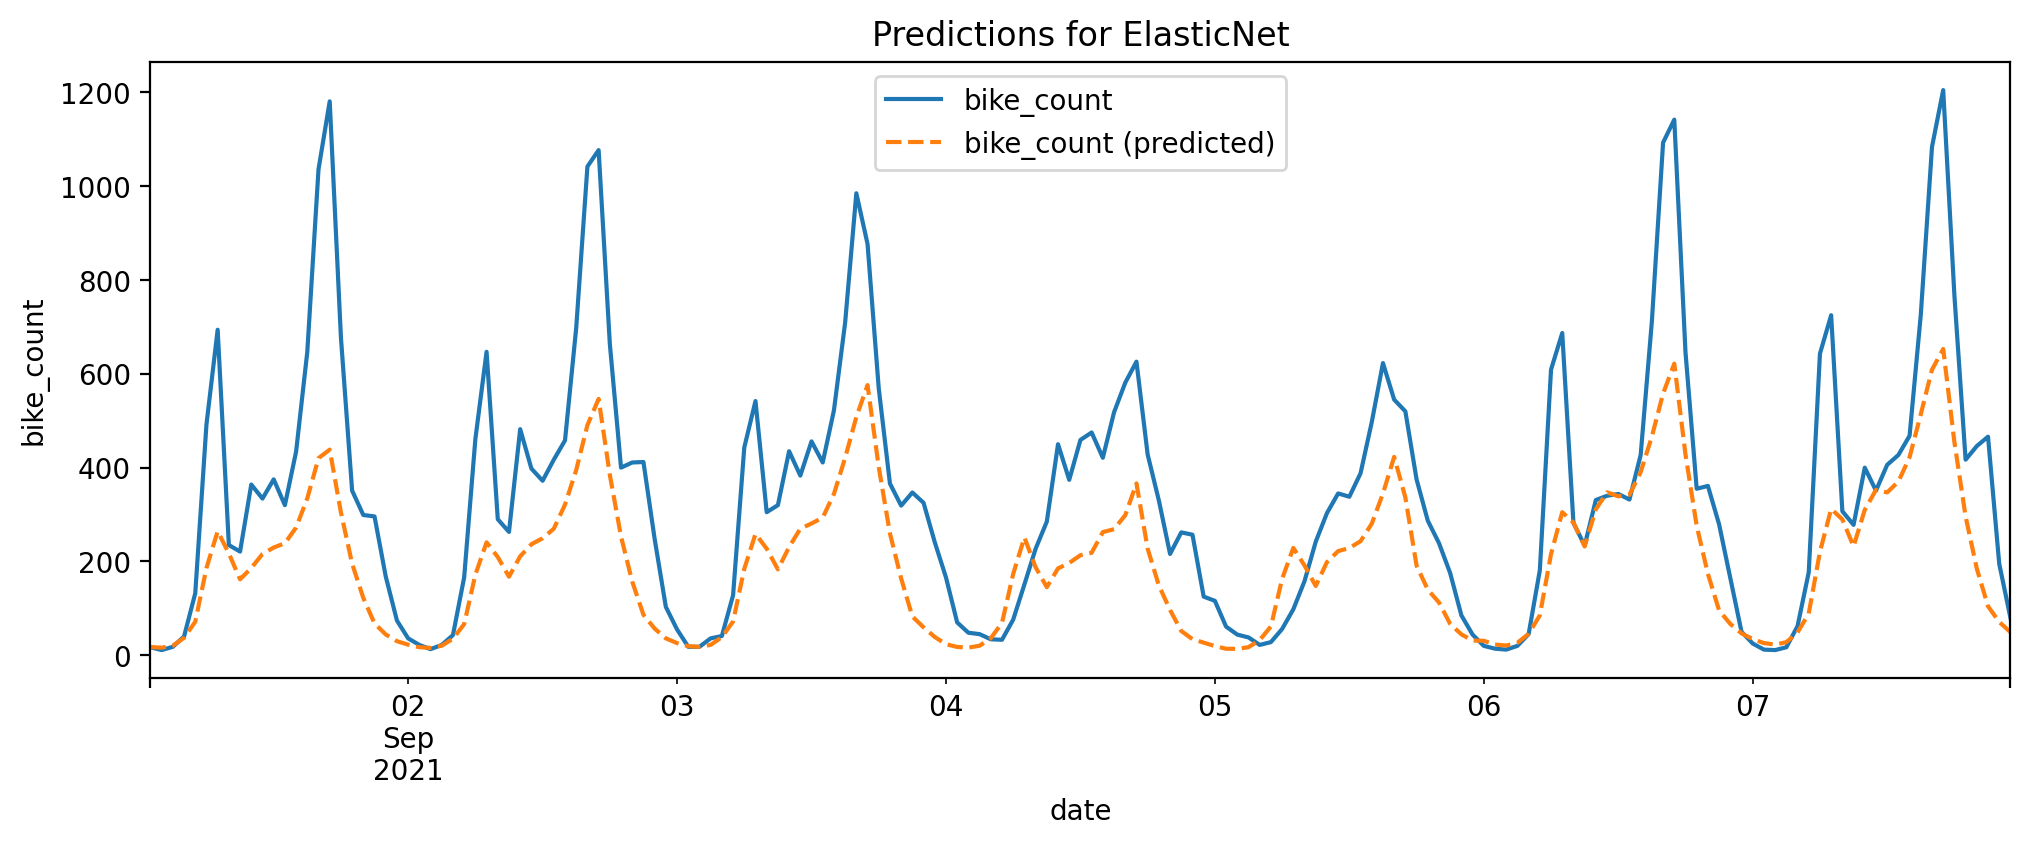

In [57]:
helper_functions.sample_week_plot(X_test, y_test_prediction, y_test, 'ElasticNet', results_path)

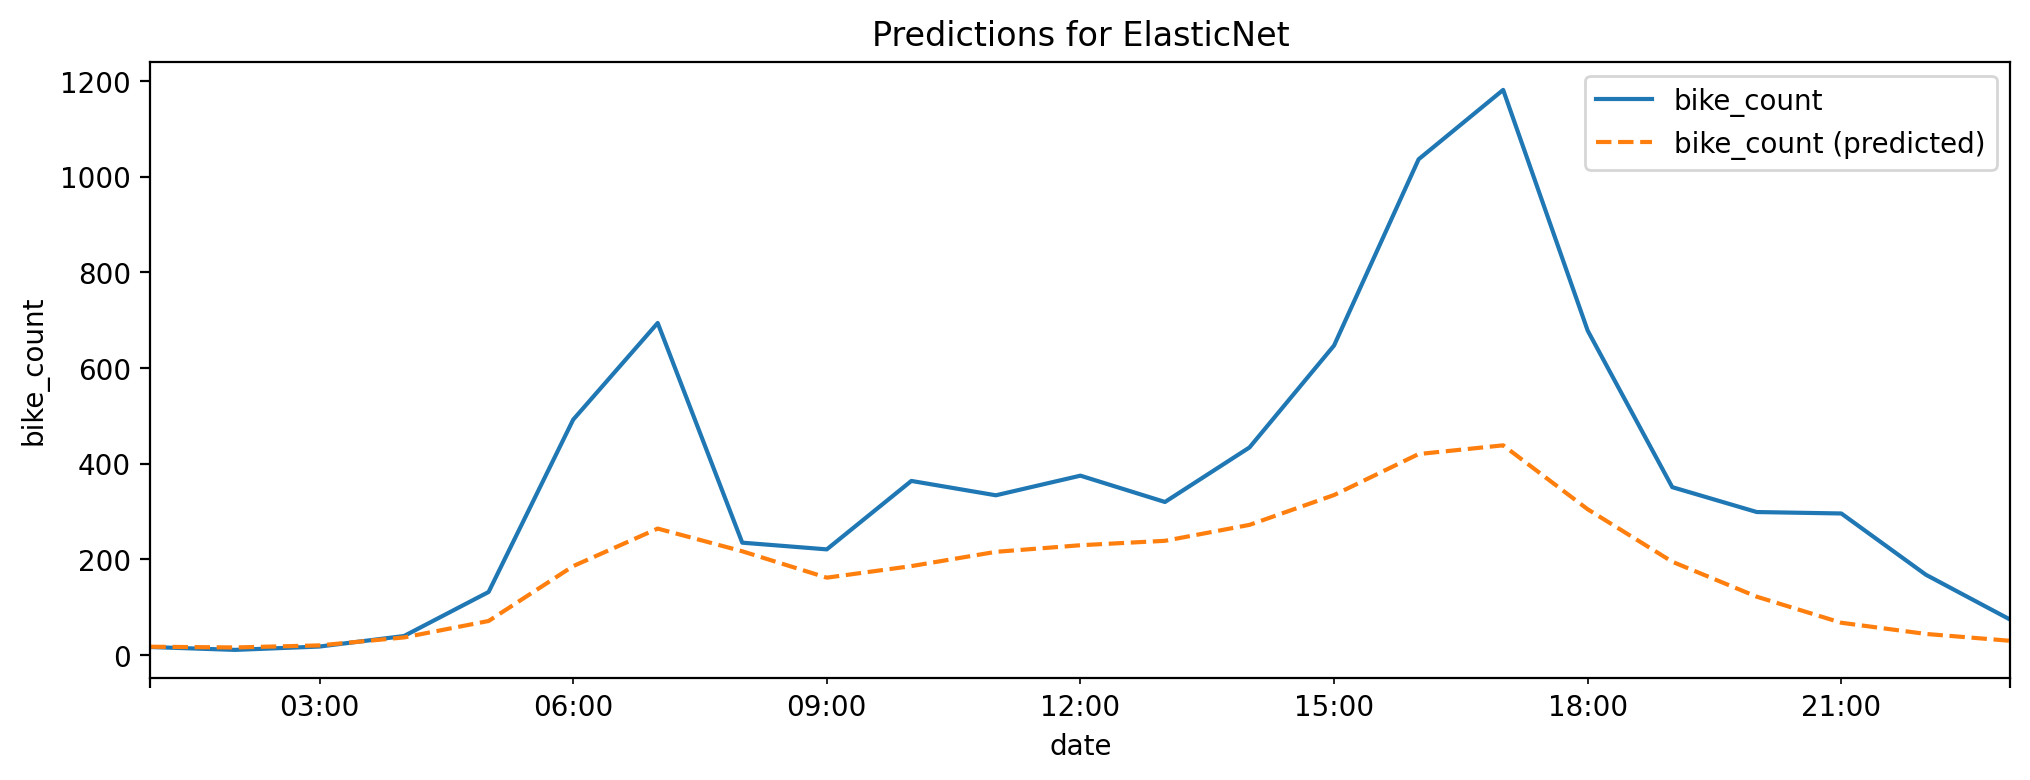

In [58]:
helper_functions.sample_day_plot(X_test, y_test_prediction, y_test, 'ElasticNet', results_path)

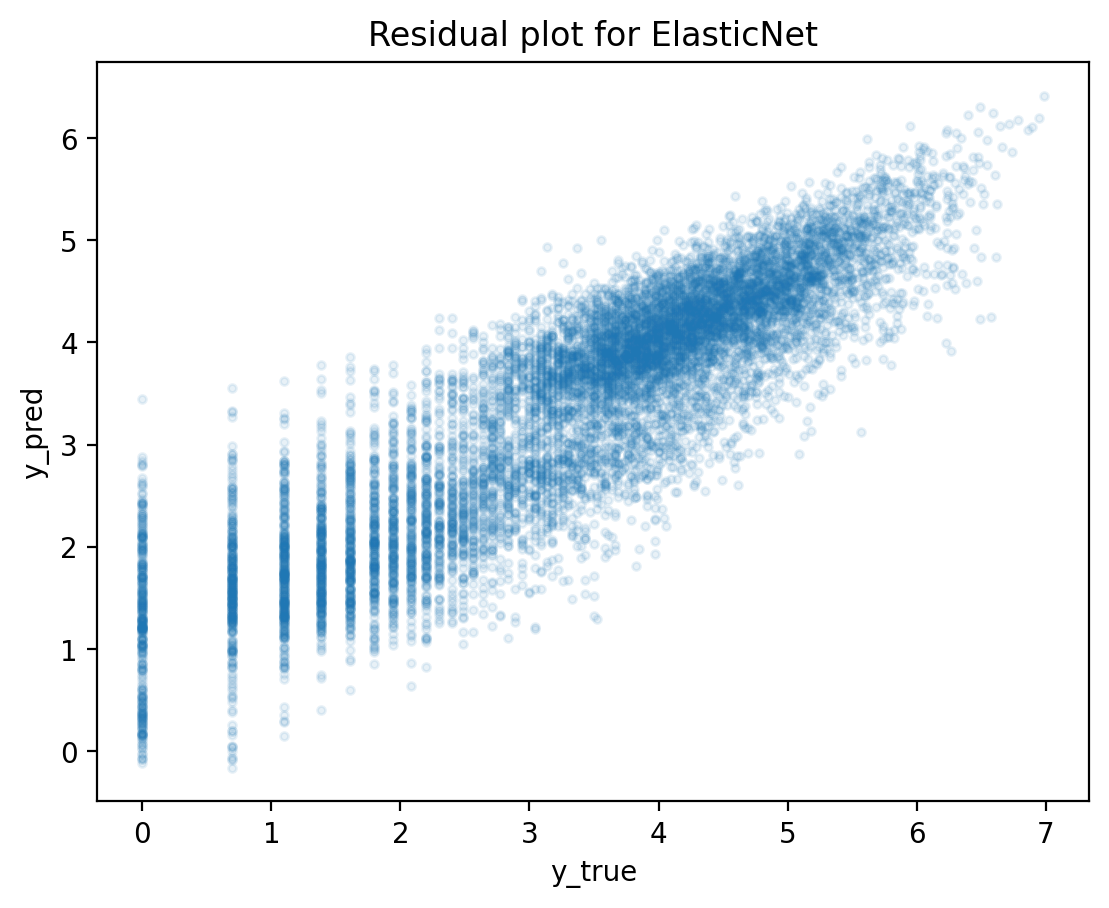

In [59]:
helper_functions.residual_plot(y_test_prediction, y_test, 'ElasticNet', results_path)

## Ridge

In [61]:
ridge_params = pd.read_csv(os.path.join(path_tuning, 'tuning_Ridge/202311271933_results.csv'))

In [62]:
ridge_max_params = ridge_params.loc[ridge_params['mean_test_score'] == ridge_params['mean_test_score'].max()]

In [63]:
best_params = ast.literal_eval(ridge_max_params.params.values[0])
params_new = {key.split('__')[1]: value for key, value in best_params.items()}

In [64]:
params_new

{'alpha': 0.9386214544664825}

In [65]:
print(f"Mean Train set, RMSE = {ridge_params['mean_train_score'].values[0]:.2f}")
print(f"Mean Test  set, RMSE = {ridge_params['mean_test_score'].values[0]:.2f}")

Mean Train set, RMSE = -0.80
Mean Test  set, RMSE = -0.93


In [66]:
# Define hyperparameters for tuning
model = Ridge(**params_new)

In [67]:
feature_transformer, data_preprocessor = init_pipe(False)
ridge_reg_pipe = make_pipeline(feature_transformer, data_preprocessor, model)
ridge_reg_pipe.fit(X_train, y_train)

y_train_prediction = ridge_reg_pipe.predict(X_train)
y_test_prediction = ridge_reg_pipe.predict(X_test)

In [68]:
print(
    f"Train set, RMSE={mean_squared_error(y_train, y_train_prediction, squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, y_test_prediction, squared=False):.2f}"
)

Train set, RMSE=0.71
Test set, RMSE=0.67


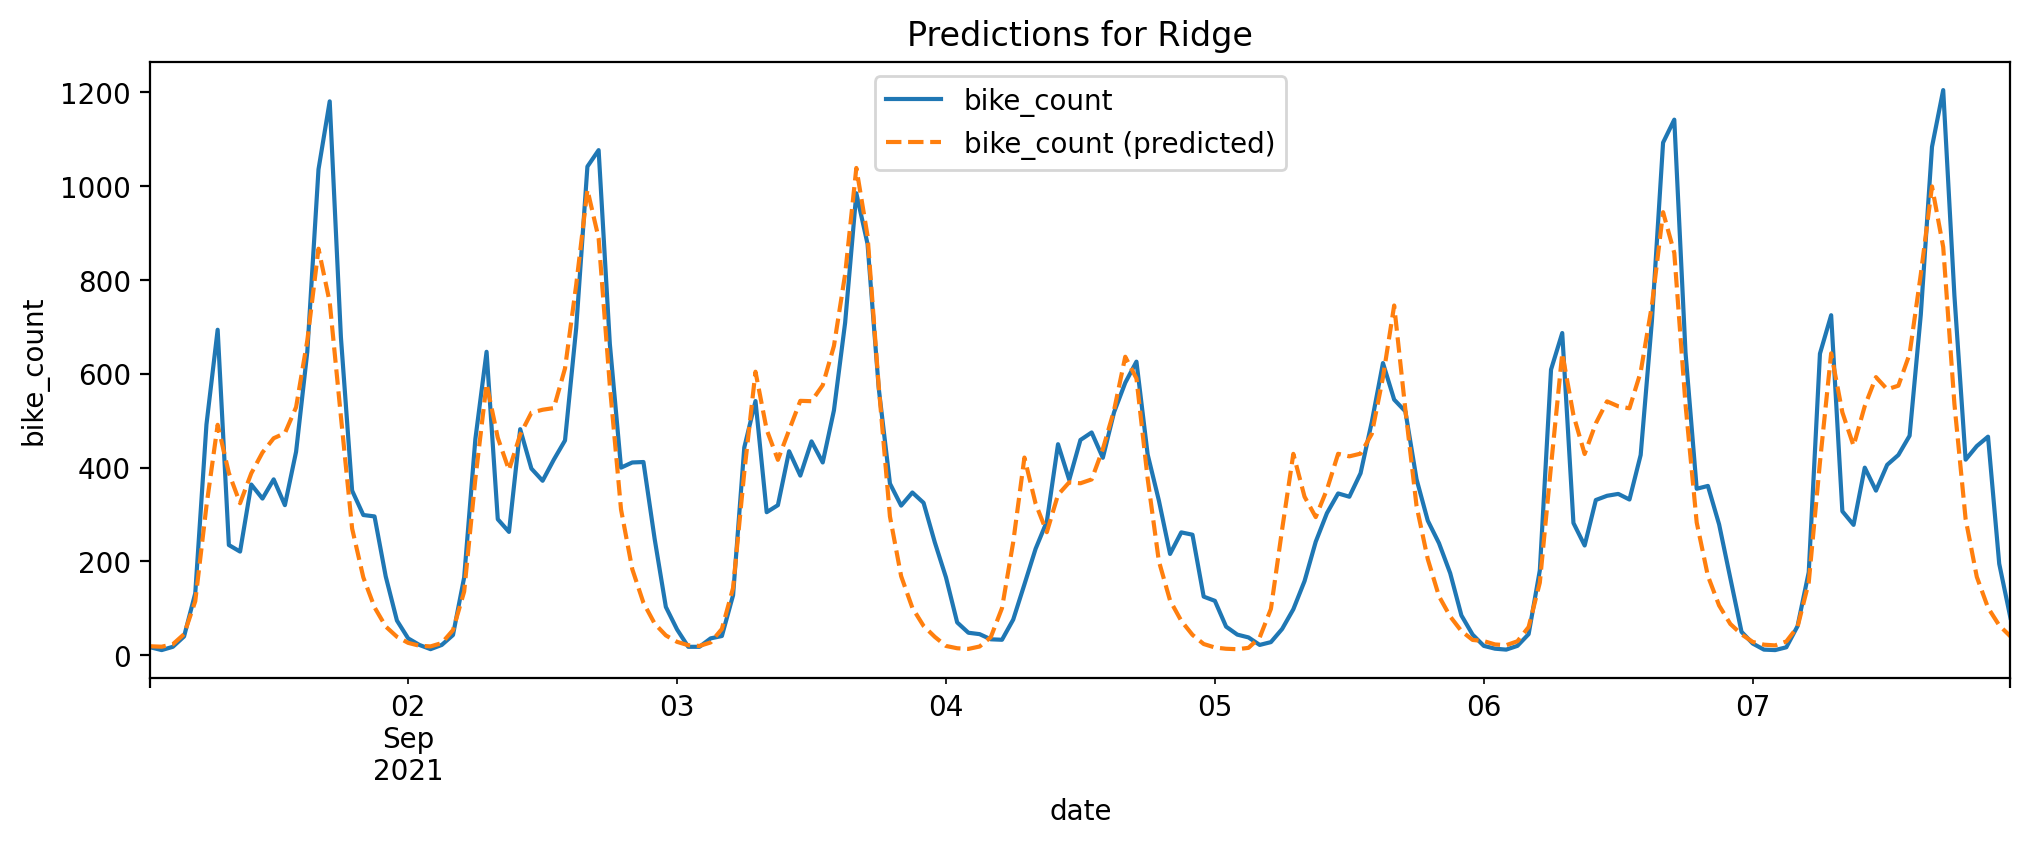

In [69]:
helper_functions.sample_week_plot(X_test, y_test_prediction, y_test, 'Ridge', results_path)

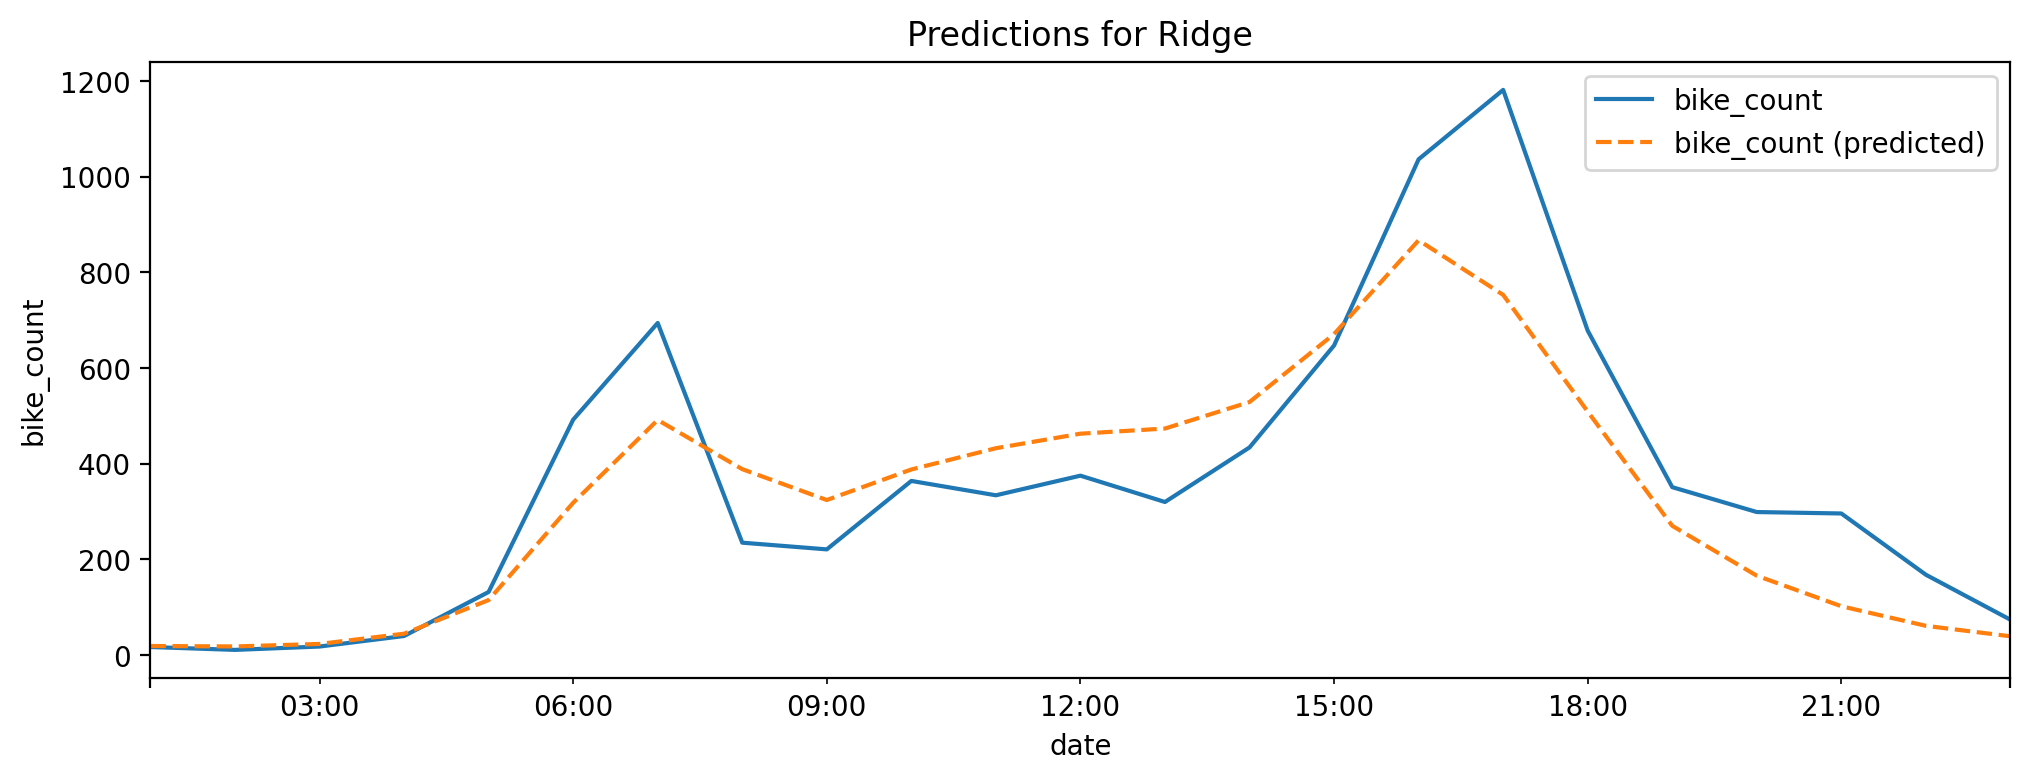

In [70]:
helper_functions.sample_day_plot(X_test, y_test_prediction, y_test, 'Ridge', results_path)

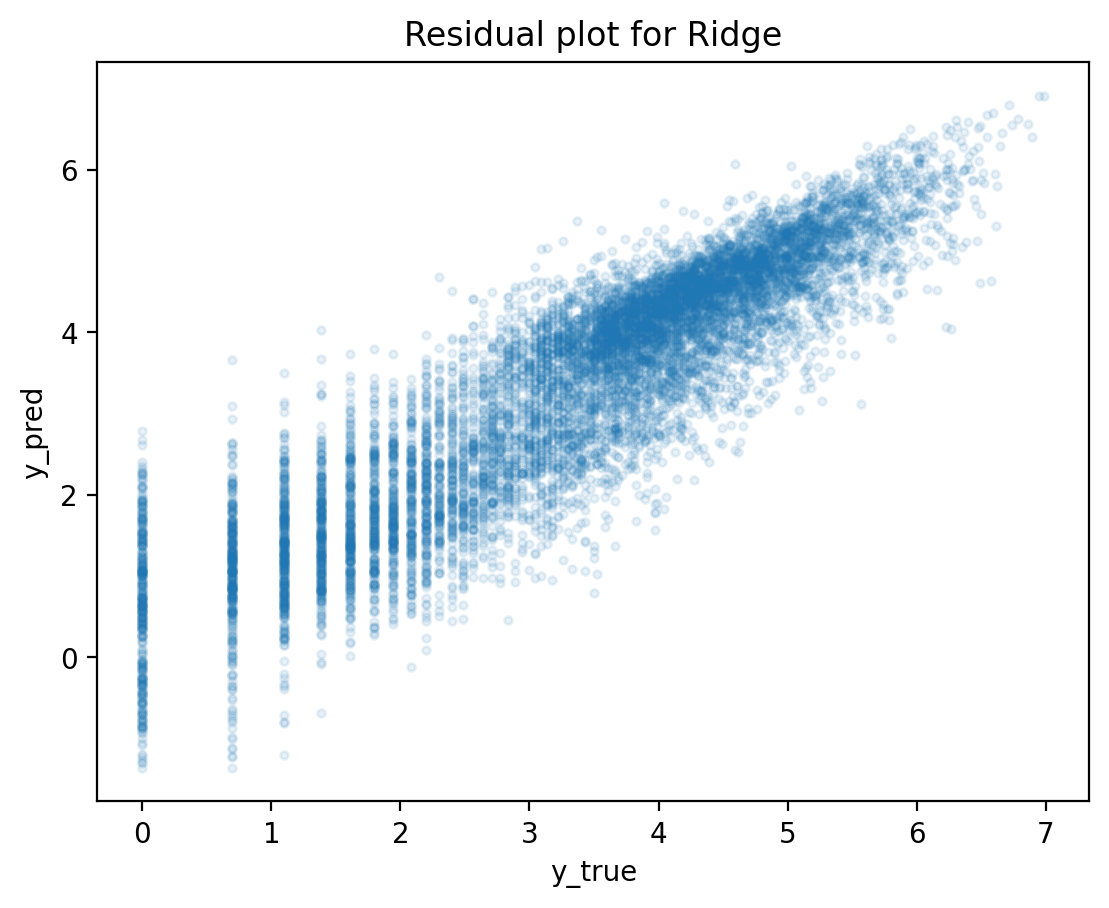

In [71]:
helper_functions.residual_plot(y_test_prediction, y_test, 'Ridge', results_path)

# Combined Analysis

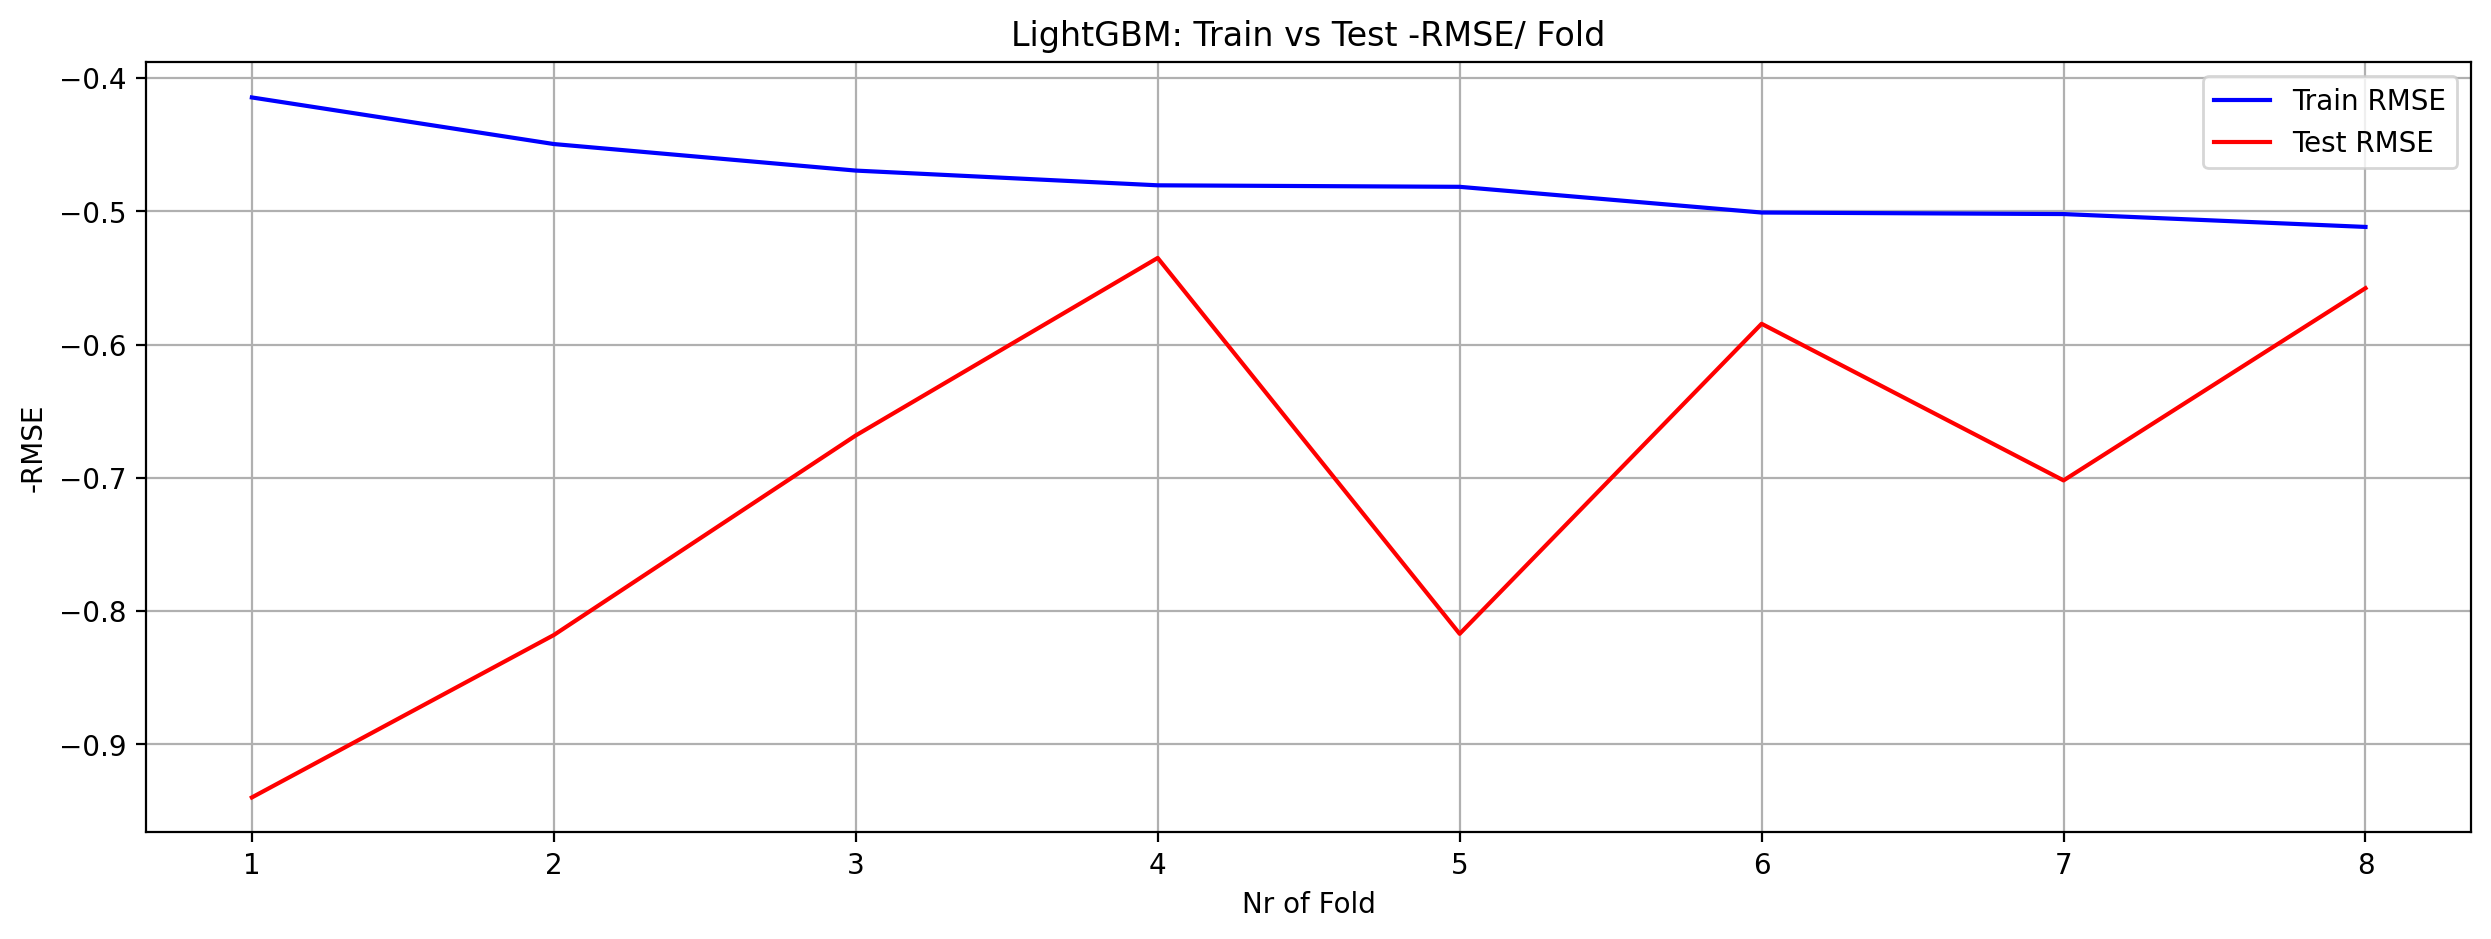

In [72]:
helper_functions.rmse_test_train_plot(light_gbm_max_params, 'LightGBM', results_path)

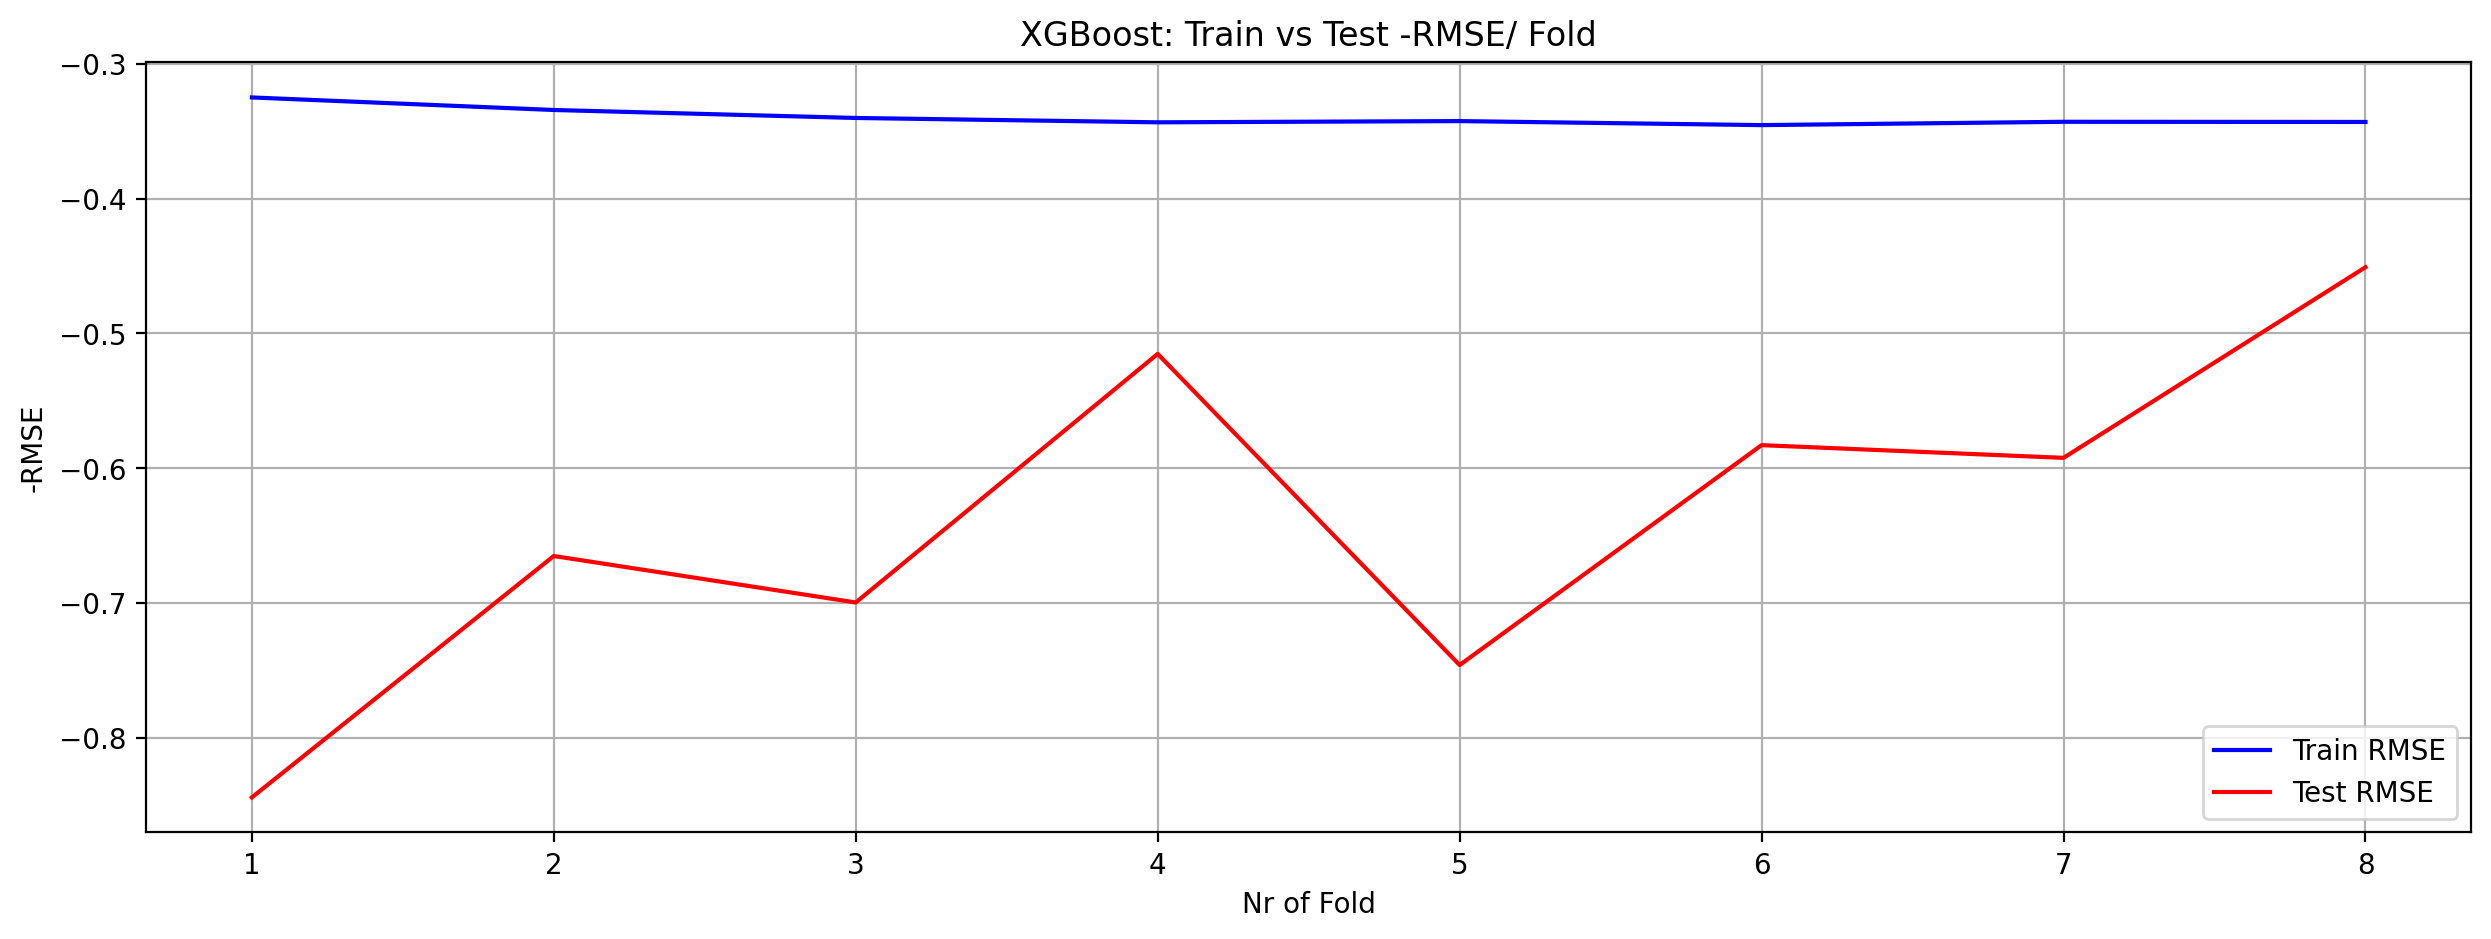

In [73]:
helper_functions.rmse_test_train_plot(xgb_max_params, 'XGBoost', results_path)

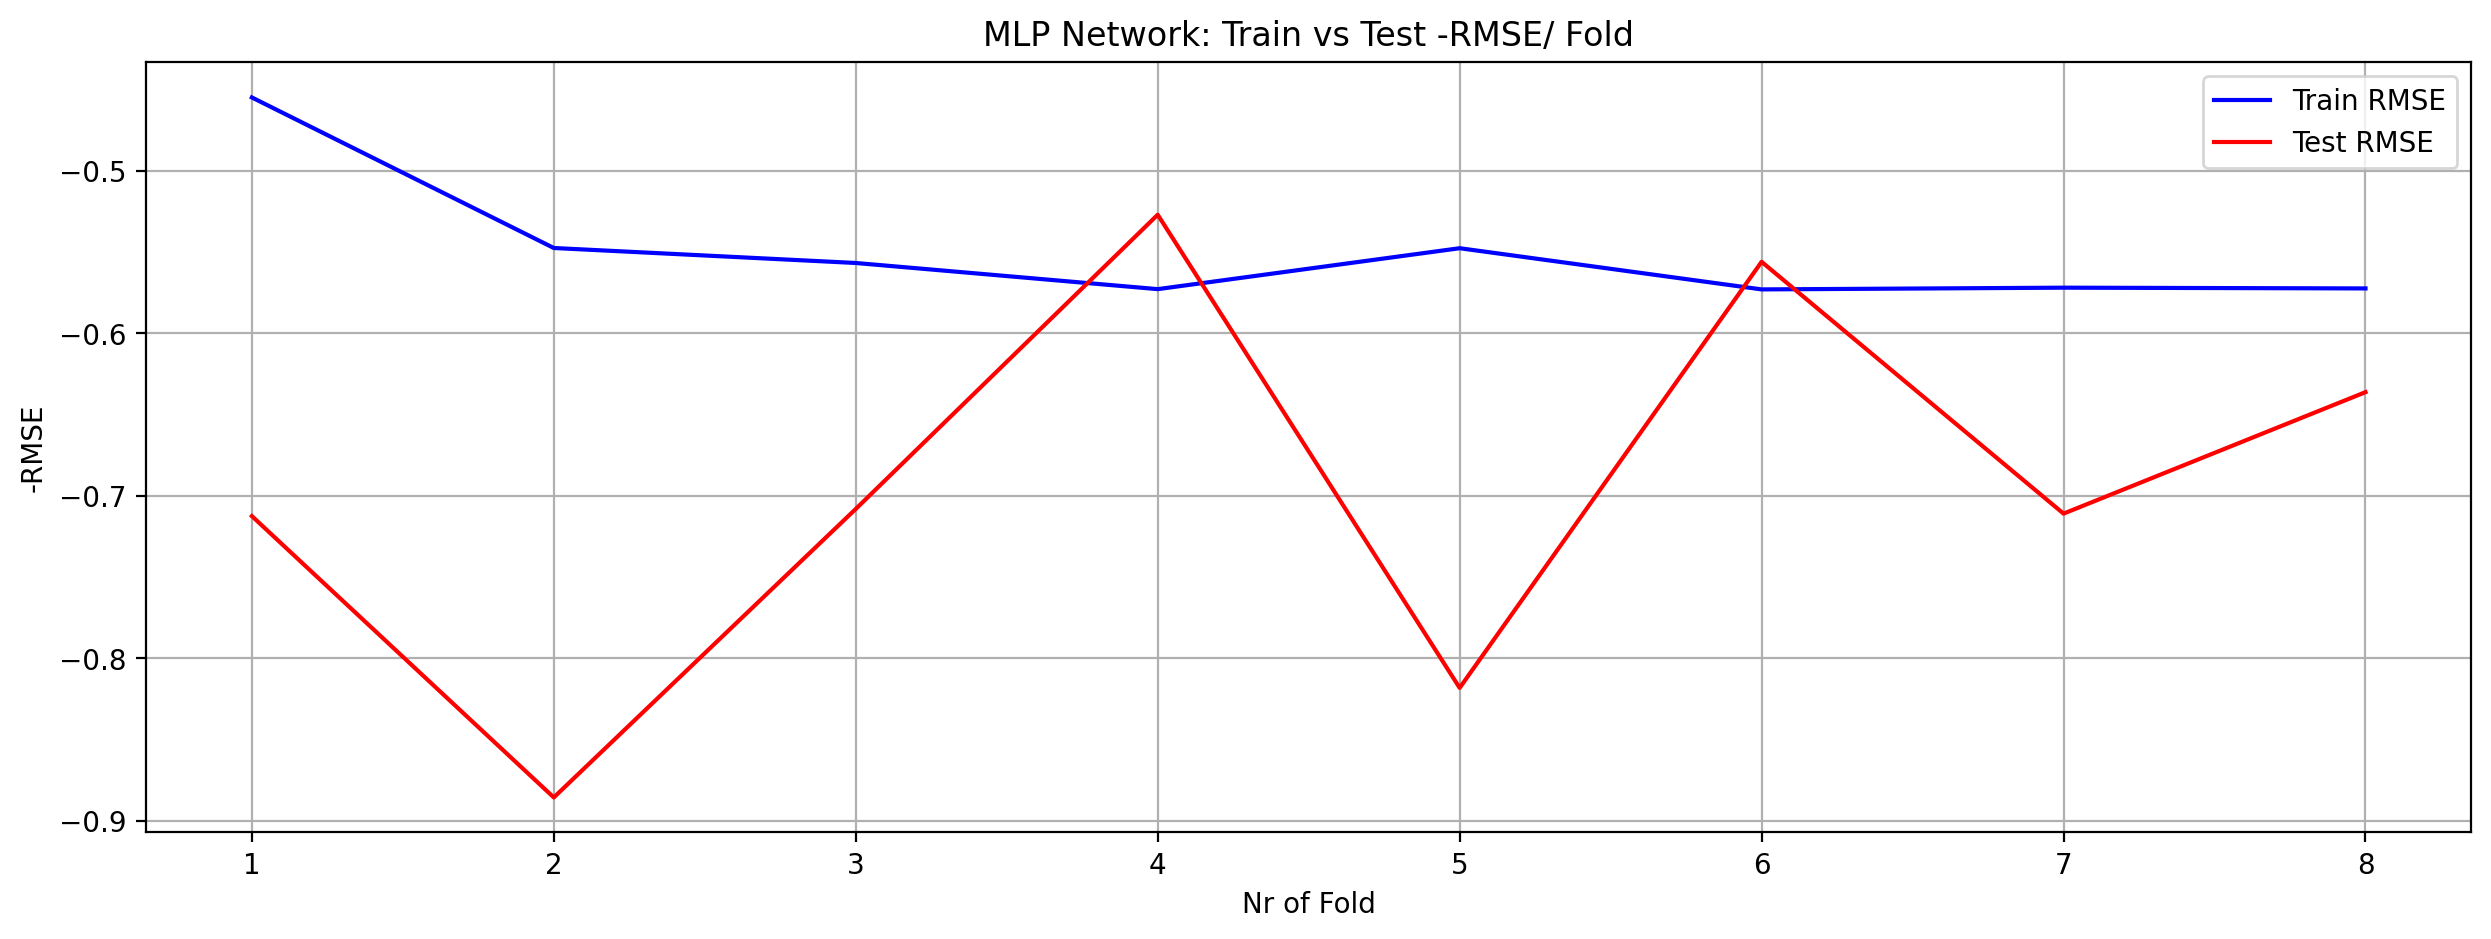

In [74]:
helper_functions.rmse_test_train_plot(mlp_max_params, 'MLP Network', results_path)

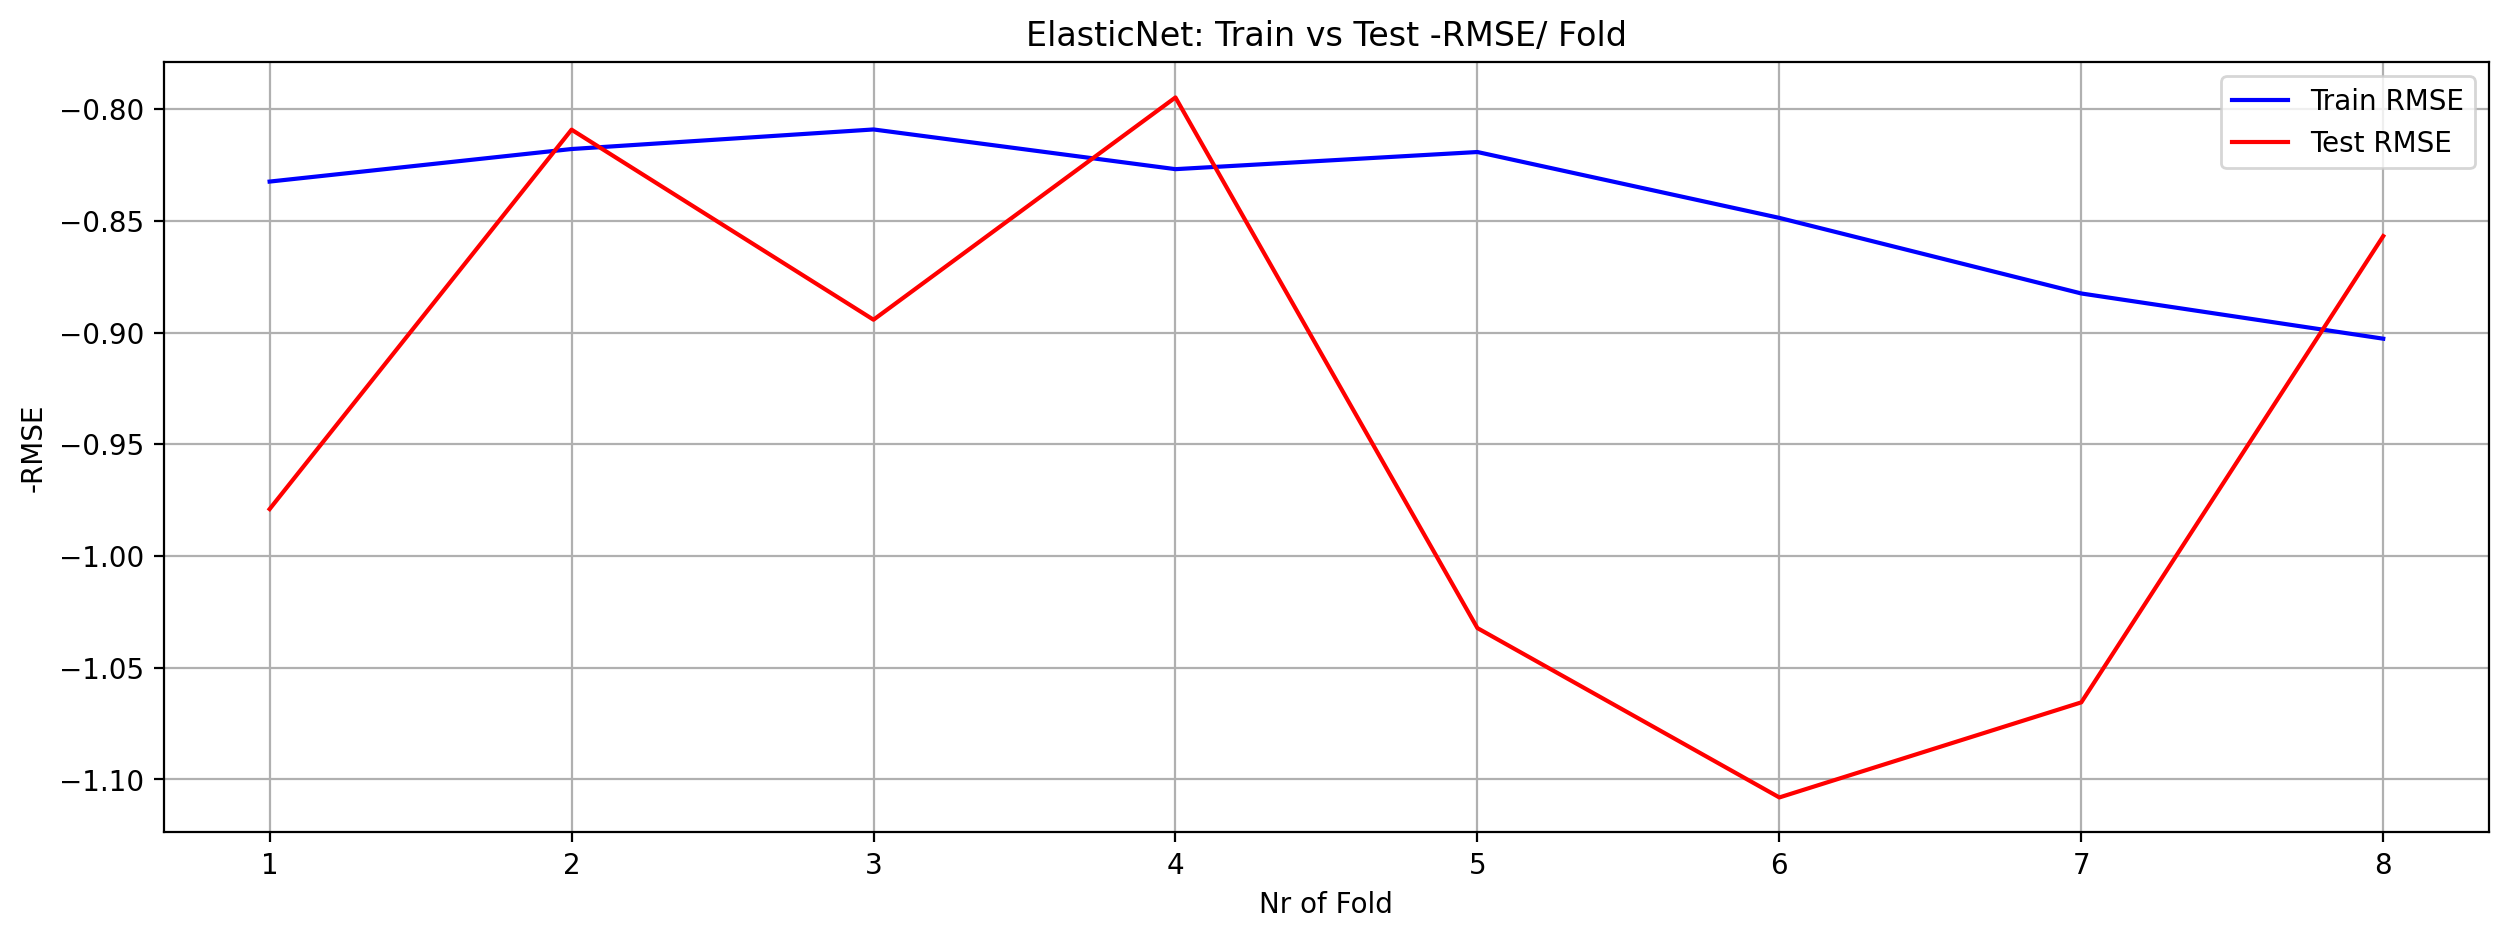

In [75]:
helper_functions.rmse_test_train_plot(elasticnet_max_params, 'ElasticNet', results_path)

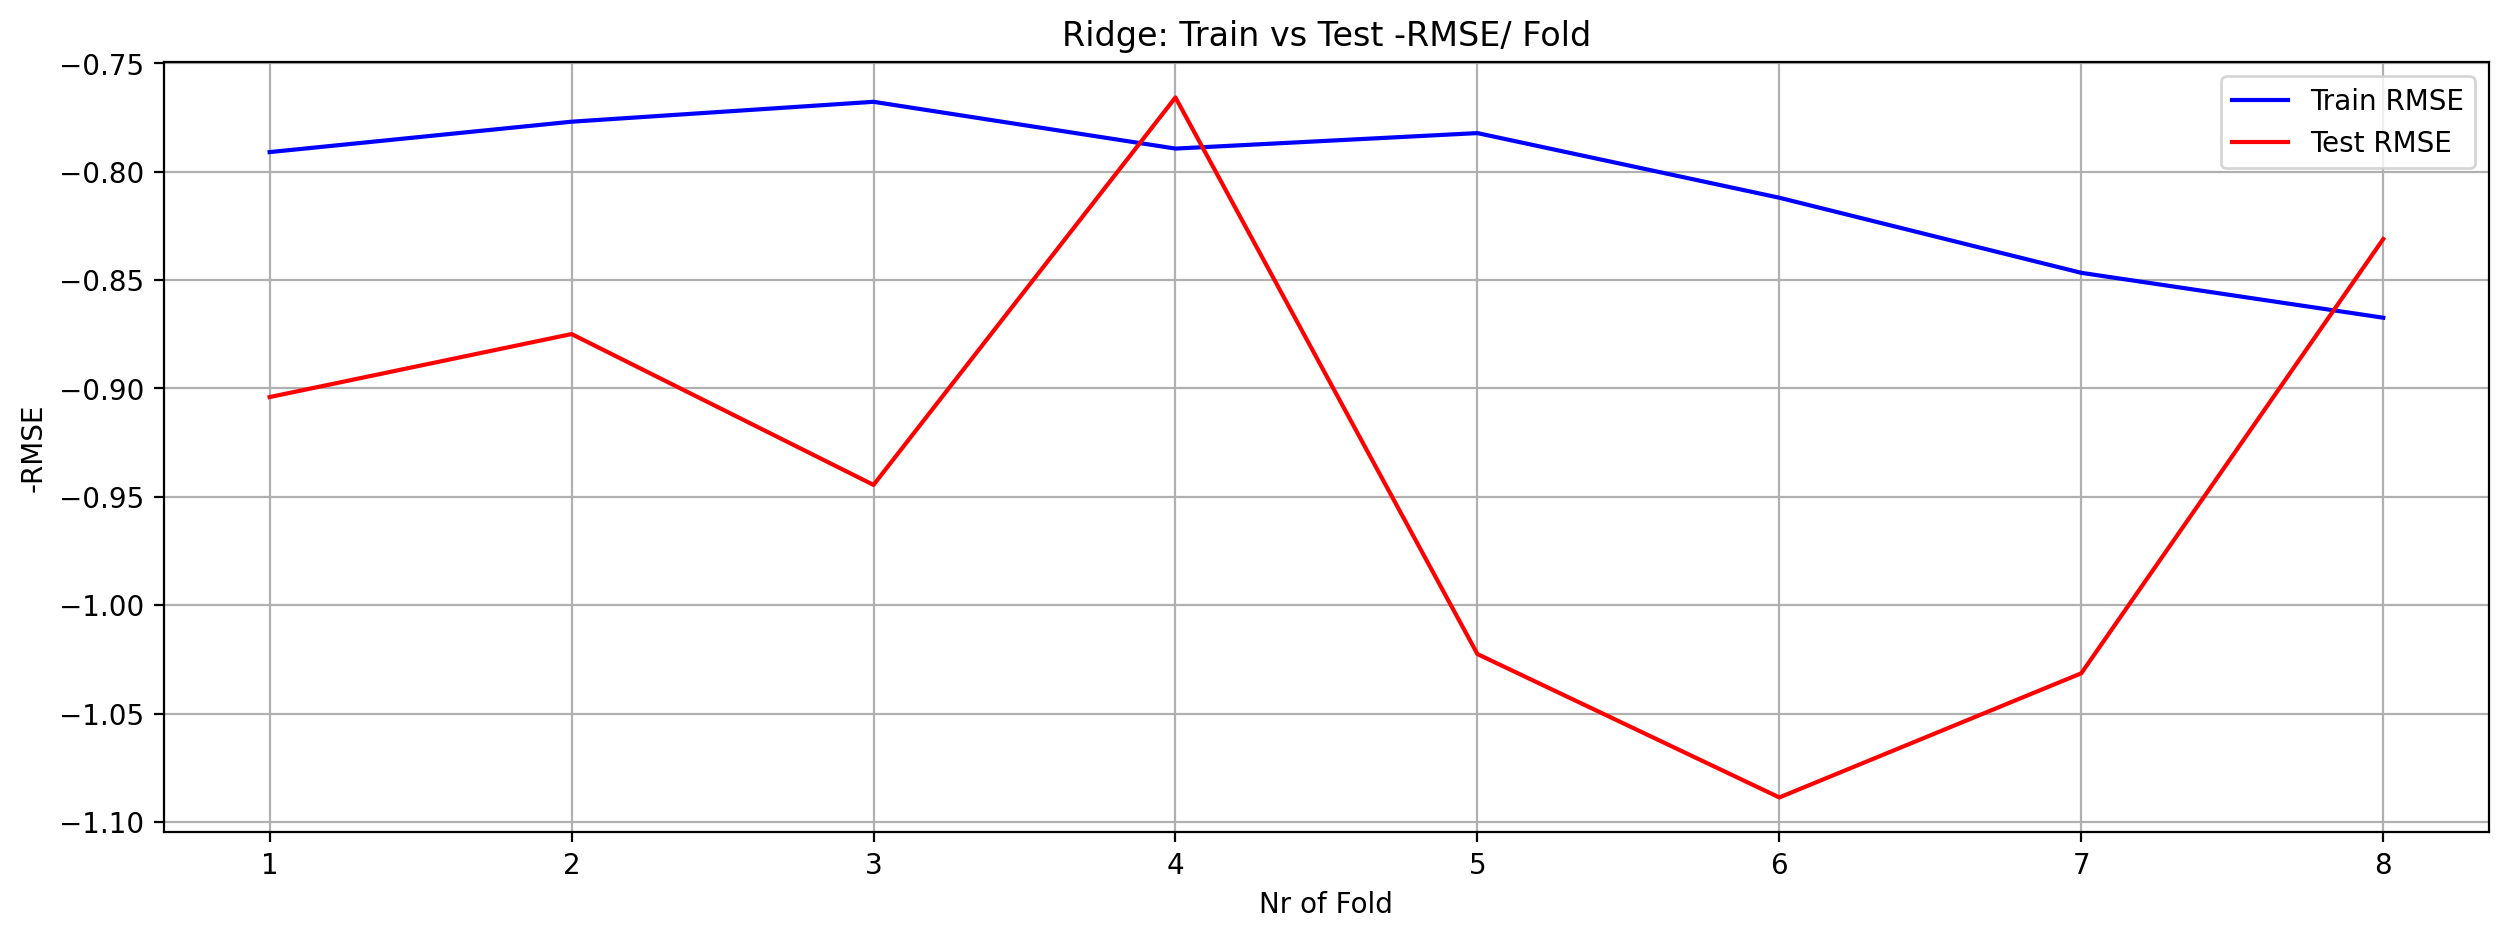

In [76]:
helper_functions.rmse_test_train_plot(ridge_max_params, 'Ridge', results_path)

In [77]:
names = ['LightGBM', 'XGBoost', 'MLP Network', 'ElasticNet', 'Ridge']
test_values = ['split0_test_score', 'split1_test_score', 'split2_test_score',
   'split3_test_score', 'split4_test_score', 'split5_test_score',
   'split6_test_score', 'split7_test_score']
train_values = ['split0_train_score',
   'split1_train_score', 'split2_train_score', 'split3_train_score',
   'split4_train_score', 'split5_train_score', 'split6_train_score',
   'split7_train_score']


results_train = []
results_test = []

for params in [light_gbm_max_params, xgb_max_params, mlp_max_params, elasticnet_max_params, ridge_max_params]:
    results_train.append(params[train_values].values[0])
    results_test.append(params[test_values].values[0])



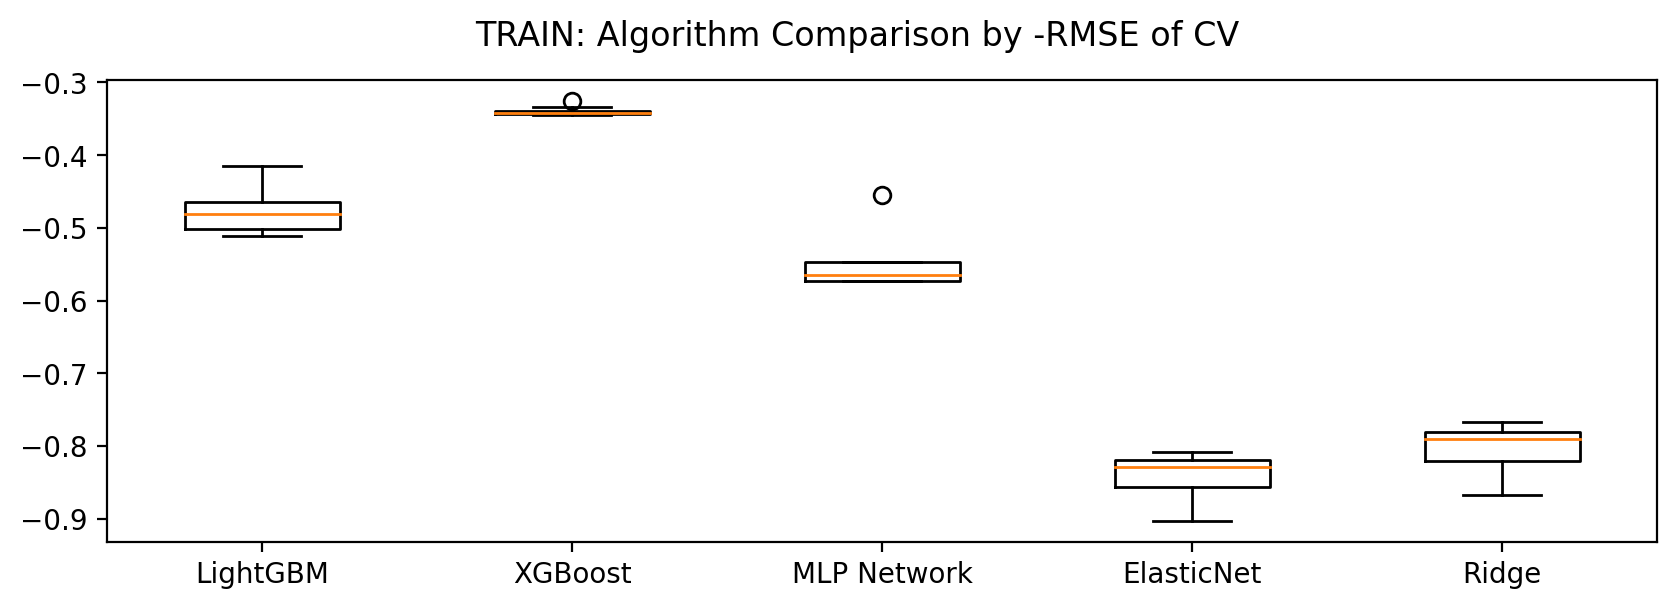

In [78]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 3))
fig.suptitle('TRAIN: Algorithm Comparison by -RMSE of CV')

ax = fig.add_subplot(111)

plt.boxplot(results_train)
ax.set_xticklabels(names)
plt.savefig(f'{results_path}/train_boxplot.png')

plt.show()

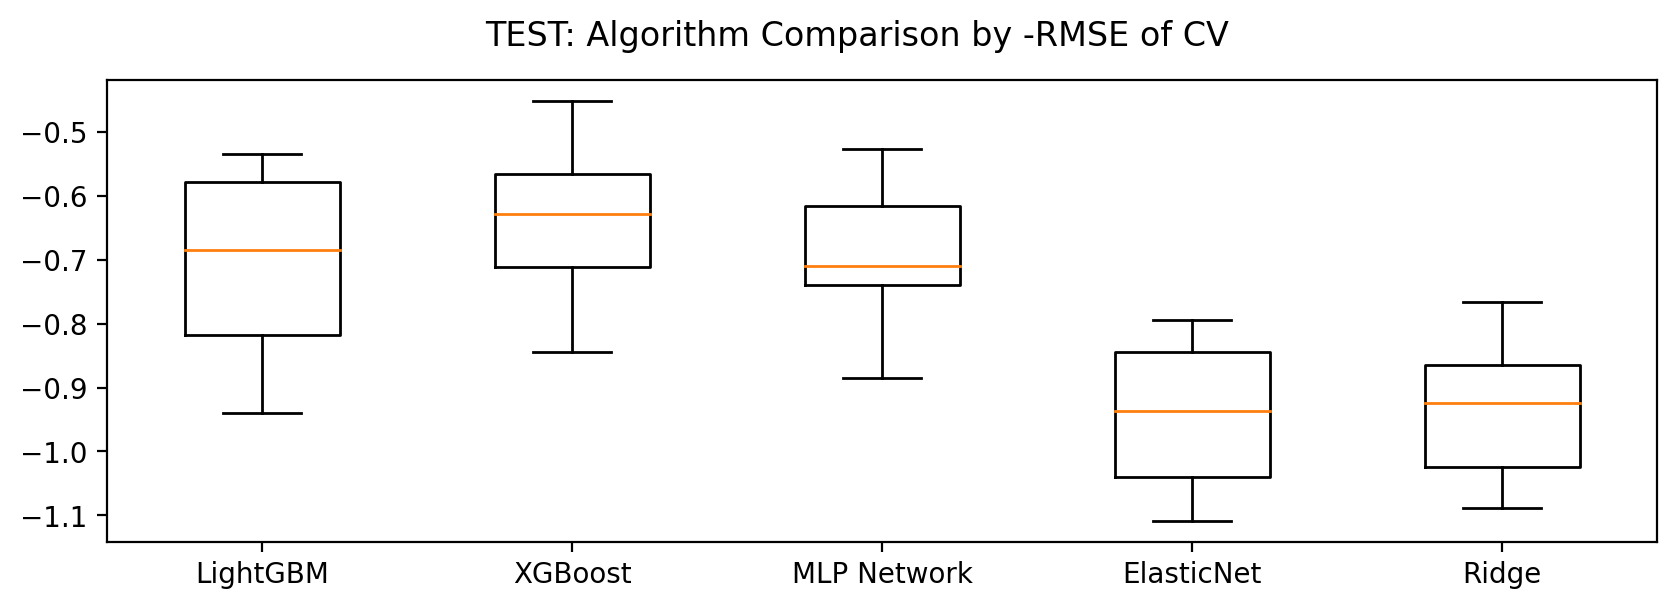

In [79]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 3))
fig.suptitle('TEST: Algorithm Comparison by -RMSE of CV')

ax = fig.add_subplot(111)

plt.boxplot(results_test)
ax.set_xticklabels(names)
plt.savefig(f'{results_path}/test_boxplot.png')

plt.show()


In [80]:
evaluation_matrix = pd.concat([light_gbm_max_params, xgb_max_params, mlp_max_params, elasticnet_max_params, ridge_max_params], ignore_index=True, axis=0)
evaluation_matrix['model'] = ['LightGBM', 'XGBoost', 'MLP Network', 'ElasticNet', 'Ridge']

evaluation_matrix = evaluation_matrix[['model', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']]


In [83]:
import dataframe_image as dfi
dfi.export(evaluation_matrix.round(2), f'{results_path}/evaluation_matrix.png')

In [89]:
dfi.export(pd.DataFrame(params_new, index=[0]).round(2).T, f'{results_path}/hyperparams.png')

